In [3]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
#import deep_inference_inference as dii
import glob
# Set styles
sns.set(style = "white")

In [254]:
def run_bayesian_t_tests_single_exp_fcn(experiment = [],
                                        experiment_meta_data = [],
                                        p_val = 0.05,
                                        n_post_samples = 10000):
    
    # Process meta dat
    n_perturb = len(np.unique(experiment_meta_data.iloc[:, 2])) - 1
    n_params = len(np.unique(experiment_meta_data.iloc[:, 1])) - 1
    
    
    base_post_estimates = experiment[1][0, :n_params]
    base_post_variances = experiment[1][0, n_params:]
    compare_post_estimates = experiment[1][1:, :n_params]
    compare_post_variances = experiment[1][1:, n_params:]
    
    base_post_samples = np.random.normal(loc = base_post_estimates, 
                                         scale = np.sqrt(base_post_variances), 
                                         size = (n_post_samples, n_params))
    
    diff_samples = np.zeros((n_perturb * n_params, n_post_samples, n_params))
    p_val_crit_array = (np.zeros((n_perturb * n_params, n_params))).astype(bool)

    i = 0
    for param in range(n_params):
        for perturb in range(n_perturb):
            compare_post_samples = np.random.normal(loc = compare_post_estimates[i], 
                                                    scale = np.sqrt(compare_post_variances[i]),
                                                    size = (n_post_samples, n_params))
            
            diff_samples[i] = (base_post_samples - compare_post_samples[i]) 
            tmp_quantiles = np.quantile(diff_samples[i],
                                        q = [(p_val / 2), p_val, 1 - p_val, 1 - (p_val / 2)], 
                                        axis = 0)
            p_val_crit_array[i, :] = (tmp_quantiles[0, :] > 0) + (tmp_quantiles[3, :] < 0)
            
            if (base_post_samples[0][param] - experiment[0][i][param]) > 0:
                p_val_crit_array[i, param] = (tmp_quantiles[1, param] > 0)
            else: 
                p_val_crit_array[i, param] = (tmp_quantiles[2, param] < 0)
            i += 1
        
    return diff_samples, np.array(p_vals), np.array(p_vals_crit), param_perturb_array


def run_bayesian_t_tests_single_exp(experiment = [0], 
                                    experiment_meta_data = [],
                                    p_val = 0.05):
    
    # Process meta dat
    n_perturb = len(np.unique(experiment_meta_data.iloc[:, 2])) - 1
    n_params = len(np.unique(experiment_meta_data.iloc[:, 1])) - 1
    
    
    base_post_samples = experiment[1][0]
    compare_post_samples = experiment[1][1:]
    diff_samples = np.zeros((compare_post_samples.shape))
    
    #print('diff_samples shape: ', diff_samples.shape)
   
    p_val_crit_array = (np.zeros((compare_post_samples.shape[0], n_params))).astype(bool)
    i = 0
    for param in range(n_params):
        for perturb in range(n_perturb):
            diff_samples[i] = (base_post_samples - compare_post_samples[i])
            tmp_quantiles = np.quantile(diff_samples[i], q = [(p_val / 2), p_val, 1 - p_val, 1 - (p_val / 2)], axis = 0)
            p_val_crit_array[i, :] = (tmp_quantiles[0, :] > 0) + (tmp_quantiles[3, :] < 0)
            
            if (base_post_samples[0][param] - experiment[0][i][param]) > 0:
                p_val_crit_array[i, param] = (tmp_quantiles[1, param] > 0)
            else: 
                p_val_crit_array[i, param] = (tmp_quantiles[2, param] < 0)
            i += 1
    
    return p_val_crit_array
   # return diff_samples, np.array(p_vals), np.array(p_vals_crit), param_perturb_array
    
def get_param_perturb_array(n_params = 0, 
                            n_perturb = 0):
    
    param_perturb_array = np.zeros(((n_params * n_perturb), n_params)).astype(bool)
    i = 0
    for param in range(n_params):
        for perturb in range(n_perturb):
            param_perturb_array[i, param] = True
        i += 1
    return param_perturb_array


def get_one_confusion_matrix(p_val_array = 0 ,
                             param_perturb_array = 0,
                             n_params = 0,
                             n_perturb = 0
                            ):
    
    # true_true --> gorundtruth: true, moel_pred: true
    true_true_cnt = np.zeros((n_perturb, n_params))
    false_false_cnt = np.zeros((n_perturb, n_params))
    true_false_cnt = np.zeros((n_perturb, n_params))
    false_true_cnt = np.zeros((n_perturb, n_params))
    
    invert_p_val_array = np.invert(p_val_array)
    invert_perturb_array = np.invert(param_perturb_array)
    i = 0
    for param in range(n_params):
        for perturb in range(n_perturb):
            #peram_slice_array = np.bool(np.zeros((p_val_array.shape)))
            spotlight_array = np.zeros((p_val_array.shape[0])).astype(bool)
            spotlight_array[i] = True
            
            true_true_cnt[perturb, param] = np.sum(np.multiply(p_val_array[:, param], spotlight_array))
            true_false_cnt[perturb, param] = 1 - true_true_cnt[perturb, param]
            false_false_cnt[:, param] += np.sum(np.multiply(invert_p_val_array[:, param], invert_perturb_array[:, param]))
            false_true_cnt[:, param] += np.sum(np.multiply(p_val_array[:, param], invert_perturb_array[:, param]))                       
            i += 1
    
    confusion_array = np.zeros((2, 2, n_perturb, n_params))
    confusion_array[0, 0] = false_false_cnt
    confusion_array[0, 1] = false_true_cnt
    confusion_array[1, 0] = true_false_cnt
    confusion_array[1, 1] = true_true_cnt
    return confusion_array
    

def bayesian_t_test_global(file_list = '',
                           meta_data = [0],
                           kind = 'posterior_samples'):
    
    n_files = len(file_list)
    
    n_perturb = len(np.unique(meta_data.iloc[:, 2])) - 1
    n_params = len(np.unique(meta_data.iloc[:, 1])) - 1
    
    param_perturb_array = get_param_perturb_array(n_params = n_params,
                                                  n_perturb = n_perturb)
    confusion_matrix_cnts = np.zeros((2, 2, n_perturb, n_params)) 

    if n_files == 0:
        print('Supply files ....')
        return 
    if n_files == 1:
        tmp_dat = pickle.load(open(file_list[0], 'rb'))
        p_vals = run_bayesian_t_tests_single_exp(experiment = tmp_dat[2],
                                                experiment_meta_data = meta_data)
        confusion_matrix_cnts = get_one_confusion_matrix(p_val_array = p_vals, 
                                                         param_perturb_array = param_perturb_array,
                                                         n_params = n_params,
                                                         n_perturb = n_perturb)

    if n_files > 1:
        for file_ in file_list:
            
            # Process file
            tmp_dat = pickle.load(open(file_, 'rb'))
            tmp_dat = [tmp_dat[0], tmp_dat[2]]
            
            if kind == 'posterior_samples':
                p_vals = run_bayesian_t_tests_single_exp(experiment = tmp_dat,
                                                         experiment_meta_data = meta_data)
                #print(p_vals)
                confusion_tmp = get_one_confusion_matrix(p_val_array = p_vals,
                                                         param_perturb_array = param_perturb_array,
                                                         n_params = n_params,
                                                         n_perturb = n_perturb)
            
            #print(confusion_tmp)
            confusion_matrix_cnts = confusion_matrix_cnts + confusion_tmp
    
    confusion_matrix_cnts[0, :] = confusion_matrix_cnts[0, :] / (confusion_matrix_cnts[0, 0] + confusion_matrix_cnts[0, 1])
    confusion_matrix_cnts[1, :] = confusion_matrix_cnts[1, :] / (confusion_matrix_cnts[1, 0] + confusion_matrix_cnts[1, 1])
    
    return confusion_matrix_cnts
    

def get_detection_ratios(t_test_results = [0]):
    n_params = len(np.unique(t_test_results[:, -2]))
    n_perturb = len(np.unique(t_test_results[:, -1]))
    n_exp_levels = n_params * n_perturb
    n_exp_by_level = out.shape[0] / n_exp_levels

    detection_ratios = np.zeros((n_perturb, n_params))

    for i in range(n_params):
        for j in range(n_perturb):
            detection_ratios[j, i] = np.sum(t_test_results[(t_test_results[:, -1] == j) & \
                                                           (t_test_results[:, -2] == i), i]) / n_exp_by_level
    return detection_ratios

# SUPPORT FUNCTIONS GRAPHS
def detection_rate_plots(ax_titles = ['v', 'a', 'w', 'ndt'], 
                         title = 'Effect detection: Bayesian T-test',
                         data = [],
                         cols = 3):
    
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)

    sns.despine(right = True)

    for i in range(len(ax_titles)):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].bar(x = ['0.05', '0.1', '0.2'], height = data[:, i])
        ax[row_tmp, col_tmp].set_xlabel('Perturbation Levels', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel('Detection Probability', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_title(ax_titles[i], 
                                       fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)

    for i in range(len(ax_titles), rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.setp(ax, yticks = [])
    return plt.show()


def confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                           title = 'Confusion Matrix',
                           data = [],
                           n_perturb = 3):
    #                       cols = 
    
    cols = len(ax_titles)
    #rows = int(np.ceil(len(ax_titles) / cols))
    rows = n_perturb
    
    sns.set(style = "white", 
            palette = "Greys", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)

    sns.despine(right = True)

    for row in range(rows):
        for col in range(cols):
            colorbar = False
            if col == (cols - 1):
                colorbar = True
            sns.heatmap(data[:, :, row, col], ax = ax[row, col],
                        vmin = 0.0, 
                        vmax = 1.0, 
                        cmap = 'Greys', 
                        cbar = colorbar,
                        annot = True,
                        annot_kws = {'fontsize': 24})

            ax[row, col].set_xlabel('Model', 
                                    fontsize = 24);
            ax[row, col].set_title(ax_titles[col], 
                                    fontsize = 30);
            ax[row, col].tick_params(axis = "x", 
                                     labelsize = 24)
            ax[row, col].tick_params(axis = "y", 
                                     labelsize = 24)
            ax[row, col].set_ylabel('True', 
                                    fontsize = 24);

    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    return plt.show()

In [240]:
out[:, :, 2, 2] #/ (out[0, 0] + out[0, 1])

array([[0.77, 0.23],
       [0.07, 0.93]])

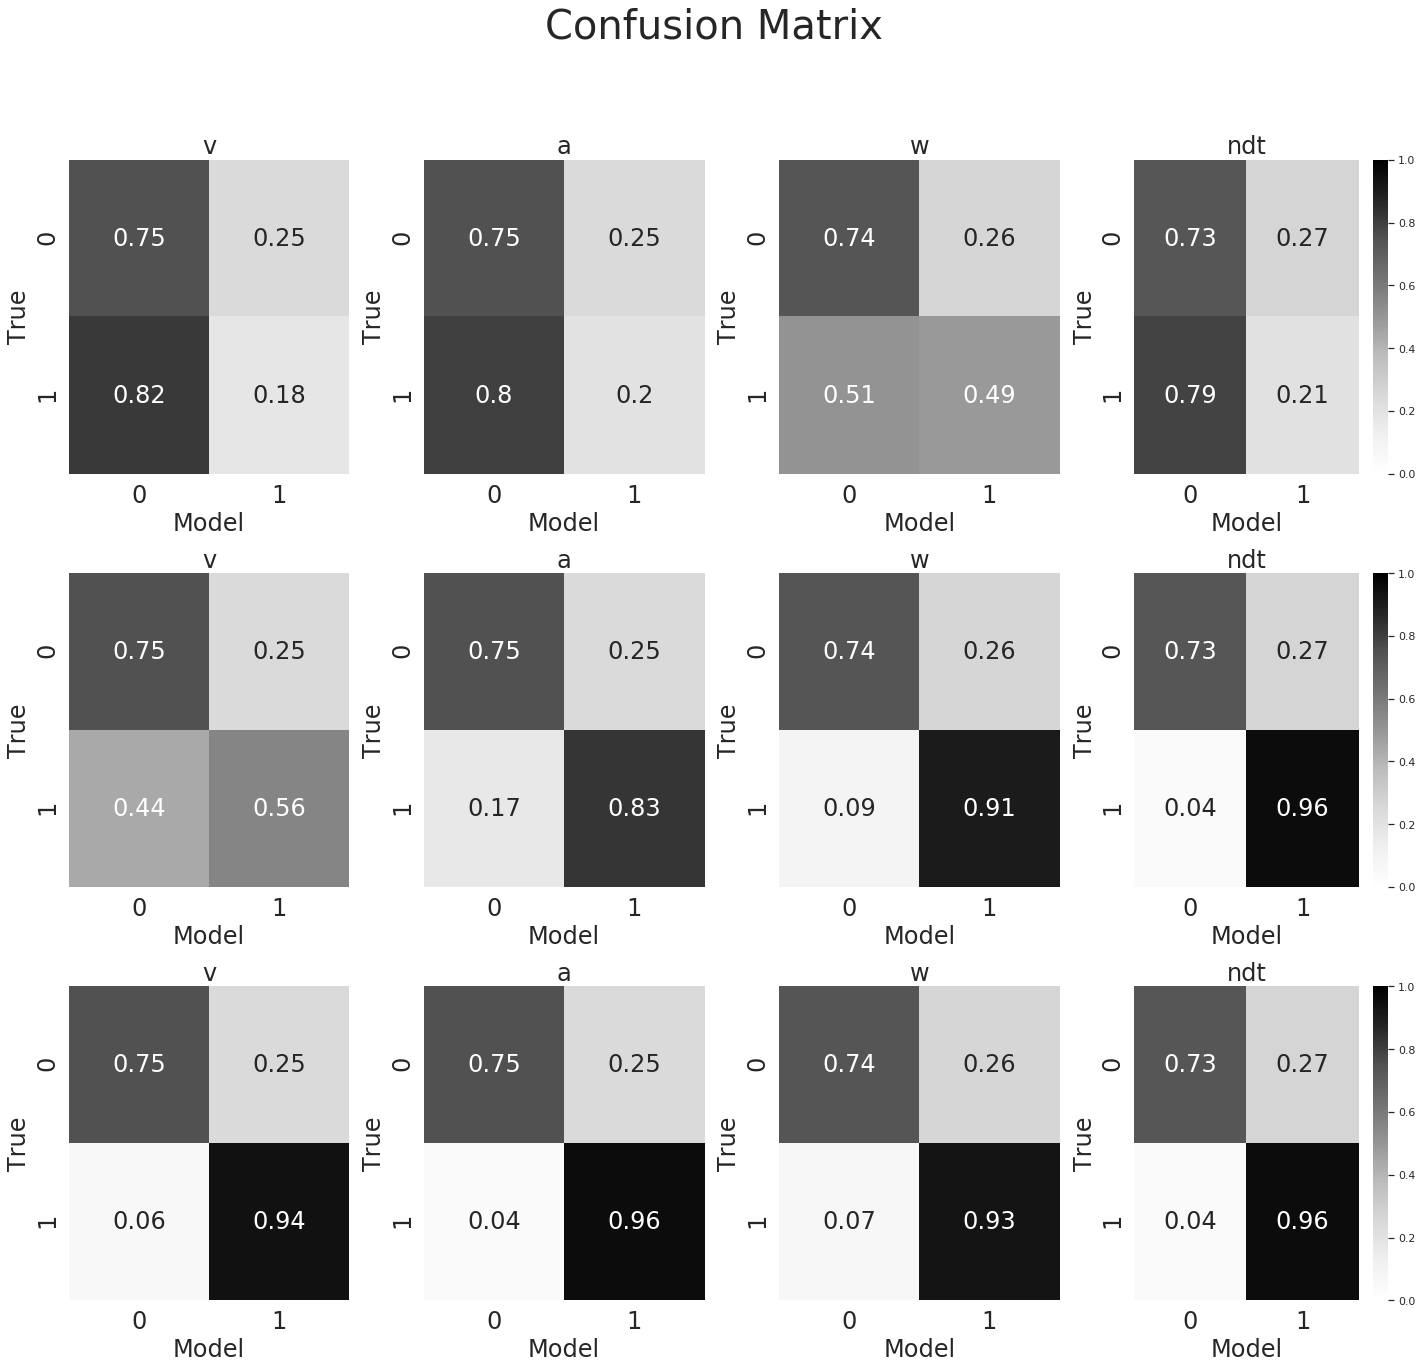

In [244]:
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 100',
                       data = out[0],
                       n_perturb = 3)

In [245]:
# Initializations
sample_sizes = [100, 250, 500, 1000, 2000, 3000]
file_folder = '/media/data_cifs/afengler/data/kde/ddm/method_comparison/'
file_base_name = file_folder + 'post_samp_perturbation_experiment_nexp_1_n_'
out = []

# Load meta_data file (assumed to be same across all experiment datasets)
meta_data = pickle.load(open(glob.glob(file_folder + 'base_data_perturbation_experiment_nexp_1*')[0], 'rb'))[2]

# Get detection ratios for all experiments
for sample_size in sample_sizes:
    files_ = glob.glob(file_base_name + str(sample_size) + '_*')
    files_.sort()
    out.append(bayesian_t_test_global(file_list = files_, meta_data = meta_data))
#     detection_ratio_list.append(get_detection_ratios(out))

[[[[33. 21. 24. 27.]
   [33. 21. 24. 27.]
   [33. 21. 24. 27.]]

  [[ 0. 12.  9.  6.]
   [ 0. 12.  9.  6.]
   [ 0. 12.  9.  6.]]]


 [[[ 1.  0.  1.  1.]
   [ 1.  1.  0.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  1.  0.  0.]
   [ 0.  0.  1.  1.]
   [ 0.  1.  1.  1.]]]]
[[[[24. 21. 24. 27.]
   [24. 21. 24. 27.]
   [24. 21. 24. 27.]]

  [[ 9. 12.  9.  6.]
   [ 9. 12.  9.  6.]
   [ 9. 12.  9.  6.]]]


 [[[ 1.  0.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  1.  1.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 27. 24. 18.]
   [24. 27. 24. 18.]
   [24. 27. 24. 18.]]

  [[ 9.  6.  9. 15.]
   [ 9.  6.  9. 15.]
   [ 9.  6.  9. 15.]]]


 [[[ 1.  1.  0.  0.]
   [ 0.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  1.]
   [ 1.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[27. 24. 24. 24.]
   [27. 24. 24. 24.]
   [27. 24. 24. 24.]]

  [[ 6.  9.  9.  9.]
   [ 6.  9.  9.  9.]
   [ 6.  9.  9.  9.]]]


 [[[ 1.  1.  0.  0.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1

[[[[24. 27. 24. 27.]
   [24. 27. 24. 27.]
   [24. 27. 24. 27.]]

  [[ 9.  6.  9.  6.]
   [ 9.  6.  9.  6.]
   [ 9.  6.  9.  6.]]]


 [[[ 0.  1.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  0.  1.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[18. 24. 33. 15.]
   [18. 24. 33. 15.]
   [18. 24. 33. 15.]]

  [[15.  9.  0. 18.]
   [15.  9.  0. 18.]
   [15.  9.  0. 18.]]]


 [[[ 1.  1.  1.  1.]
   [ 0.  0.  1.  0.]
   [ 0.  0.  1.  0.]]

  [[ 0.  0.  0.  0.]
   [ 1.  1.  0.  1.]
   [ 1.  1.  0.  1.]]]]
[[[[33. 27. 24. 27.]
   [33. 27. 24. 27.]
   [33. 27. 24. 27.]]

  [[ 0.  6.  9.  6.]
   [ 0.  6.  9.  6.]
   [ 0.  6.  9.  6.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  0.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  0.  1.  1.]
   [ 0.  1.  1.  1.]]]]
[[[[24. 33. 30. 33.]
   [24. 33. 30. 33.]
   [24. 33. 30. 33.]]

  [[ 9.  0.  3.  0.]
   [ 9.  0.  3.  0.]
   [ 9.  0.  3.  0.]]]


 [[[ 1.  1.  1.  1.]
   [ 0.  1.  1.  1.]
   [ 0.  1.  0.  1.]]

  [[ 0.  0.  0

[[[[33. 27. 27. 27.]
   [33. 27. 27. 27.]
   [33. 27. 27. 27.]]

  [[ 0.  6.  6.  6.]
   [ 0.  6.  6.  6.]
   [ 0.  6.  6.  6.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  0.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  0.  1.  1.]
   [ 0.  1.  1.  1.]]]]
[[[[30. 27. 30. 24.]
   [30. 27. 30. 24.]
   [30. 27. 30. 24.]]

  [[ 3.  6.  3.  9.]
   [ 3.  6.  3.  9.]
   [ 3.  6.  3.  9.]]]


 [[[ 1.  1.  1.  0.]
   [ 1.  0.  1.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  0.  0.  1.]
   [ 0.  1.  0.  1.]
   [ 0.  1.  1.  1.]]]]
[[[[33. 24. 30. 33.]
   [33. 24. 30. 33.]
   [33. 24. 30. 33.]]

  [[ 0.  9.  3.  0.]
   [ 0.  9.  3.  0.]
   [ 0.  9.  3.  0.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  0.  1.  1.]
   [ 1.  0.  0.  1.]]

  [[ 0.  0.  0.  0.]
   [ 0.  1.  0.  0.]
   [ 0.  1.  1.  0.]]]]
[[[[24. 27. 27. 27.]
   [24. 27. 27. 27.]
   [24. 27. 27. 27.]]

  [[ 9.  6.  6.  6.]
   [ 9.  6.  6.  6.]
   [ 9.  6.  6.  6.]]]


 [[[ 1.  1.  1.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0

[[[[33. 30. 33. 30.]
   [33. 30. 33. 30.]
   [33. 30. 33. 30.]]

  [[ 0.  3.  0.  3.]
   [ 0.  3.  0.  3.]
   [ 0.  3.  0.  3.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  1.]]]]
[[[[30. 27. 27. 24.]
   [30. 27. 27. 24.]
   [30. 27. 27. 24.]]

  [[ 3.  6.  6.  9.]
   [ 3.  6.  6.  9.]
   [ 3.  6.  6.  9.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  0.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  0.  1.  1.]
   [ 0.  1.  1.  1.]]]]
[[[[15. 30. 33. 18.]
   [15. 30. 33. 18.]
   [15. 30. 33. 18.]]

  [[18.  3.  0. 15.]
   [18.  3.  0. 15.]
   [18.  3.  0. 15.]]]


 [[[ 0.  1.  1.  0.]
   [ 0.  1.  1.  0.]
   [ 0.  1.  1.  0.]]

  [[ 1.  0.  0.  1.]
   [ 1.  0.  0.  1.]
   [ 1.  0.  0.  1.]]]]
[[[[33. 24. 27. 27.]
   [33. 24. 27. 27.]
   [33. 24. 27. 27.]]

  [[ 0.  9.  6.  6.]
   [ 0.  9.  6.  6.]
   [ 0.  9.  6.  6.]]]


 [[[ 1.  1.  0.  1.]
   [ 1.  1.  1.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  0.  1

[[[[24. 33. 27. 27.]
   [24. 33. 27. 27.]
   [24. 33. 27. 27.]]

  [[ 9.  0.  6.  6.]
   [ 9.  0.  6.  6.]
   [ 9.  0.  6.  6.]]]


 [[[ 1.  1.  0.  1.]
   [ 0.  1.  1.  1.]
   [ 1.  1.  0.  0.]]

  [[ 0.  0.  1.  0.]
   [ 1.  0.  0.  0.]
   [ 0.  0.  1.  1.]]]]
[[[[30. 30. 24. 27.]
   [30. 30. 24. 27.]
   [30. 30. 24. 27.]]

  [[ 3.  3.  9.  6.]
   [ 3.  3.  9.  6.]
   [ 3.  3.  9.  6.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[27. 33. 24. 30.]
   [27. 33. 24. 30.]
   [27. 33. 24. 30.]]

  [[ 6.  0.  9.  3.]
   [ 6.  0.  9.  3.]
   [ 6.  0.  9.  3.]]]


 [[[ 1.  1.  0.  1.]
   [ 0.  1.  0.  1.]
   [ 0.  1.  0.  0.]]

  [[ 0.  0.  1.  0.]
   [ 1.  0.  1.  0.]
   [ 1.  0.  1.  1.]]]]
[[[[24. 24. 27. 21.]
   [24. 24. 27. 21.]
   [24. 24. 27. 21.]]

  [[ 9.  9.  6. 12.]
   [ 9.  9.  6. 12.]
   [ 9.  9.  6. 12.]]]


 [[[ 0.  1.  1.  1.]
   [ 0.  0.  1.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  0.  0

[[[[21. 24. 21. 33.]
   [21. 24. 21. 33.]
   [21. 24. 21. 33.]]

  [[12.  9. 12.  0.]
   [12.  9. 12.  0.]
   [12.  9. 12.  0.]]]


 [[[ 1.  1.  1.  1.]
   [ 0.  1.  0.  1.]
   [ 0.  0.  0.  1.]]

  [[ 0.  0.  0.  0.]
   [ 1.  0.  1.  0.]
   [ 1.  1.  1.  0.]]]]
[[[[30. 24. 21. 27.]
   [30. 24. 21. 27.]
   [30. 24. 21. 27.]]

  [[ 3.  9. 12.  6.]
   [ 3.  9. 12.  6.]
   [ 3.  9. 12.  6.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  0.  0.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  1.  1.  1.]
   [ 0.  1.  1.  1.]]]]
[[[[21. 24. 33. 21.]
   [21. 24. 33. 21.]
   [21. 24. 33. 21.]]

  [[12.  9.  0. 12.]
   [12.  9.  0. 12.]
   [12.  9.  0. 12.]]]


 [[[ 1.  1.  1.  1.]
   [ 0.  0.  1.  0.]
   [ 0.  0.  1.  0.]]

  [[ 0.  0.  0.  0.]
   [ 1.  1.  0.  1.]
   [ 1.  1.  0.  1.]]]]
[[[[27. 18. 33. 21.]
   [27. 18. 33. 21.]
   [27. 18. 33. 21.]]

  [[ 6. 15.  0. 12.]
   [ 6. 15.  0. 12.]
   [ 6. 15.  0. 12.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  1.  0.]
   [ 0.  0.  1.  0.]]

  [[ 0.  0.  0

[[[[33. 30. 18. 27.]
   [33. 30. 18. 27.]
   [33. 30. 18. 27.]]

  [[ 0.  3. 15.  6.]
   [ 0.  3. 15.  6.]
   [ 0.  3. 15.  6.]]]


 [[[ 1.  1.  0.  1.]
   [ 1.  1.  0.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  0.  1.  0.]
   [ 0.  0.  1.  1.]
   [ 0.  1.  1.  1.]]]]
[[[[24. 30. 24. 27.]
   [24. 30. 24. 27.]
   [24. 30. 24. 27.]]

  [[ 9.  3.  9.  6.]
   [ 9.  3.  9.  6.]
   [ 9.  3.  9.  6.]]]


 [[[ 1.  1.  0.  1.]
   [ 0.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  0.]
   [ 1.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[30. 15. 33. 24.]
   [30. 15. 33. 24.]
   [30. 15. 33. 24.]]

  [[ 3. 18.  0.  9.]
   [ 3. 18.  0.  9.]
   [ 3. 18.  0.  9.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  1.  0.]
   [ 1.  0.  1.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  0.  0.  1.]
   [ 0.  1.  0.  1.]]]]
[[[[21. 12. 24. 27.]
   [21. 12. 24. 27.]
   [21. 12. 24. 27.]]

  [[12. 21.  9.  6.]
   [12. 21.  9.  6.]
   [12. 21.  9.  6.]]]


 [[[ 0.  1.  0.  1.]
   [ 1.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  0.  1

[[[[24. 27. 24. 27.]
   [24. 27. 24. 27.]
   [24. 27. 24. 27.]]

  [[ 9.  6.  9.  6.]
   [ 9.  6.  9.  6.]
   [ 9.  6.  9.  6.]]]


 [[[ 0.  1.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  0.  1.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 24. 21. 24.]
   [24. 24. 21. 24.]
   [24. 24. 21. 24.]]

  [[ 9.  9. 12.  9.]
   [ 9.  9. 12.  9.]
   [ 9.  9. 12.  9.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[15. 24. 30. 12.]
   [15. 24. 30. 12.]
   [15. 24. 30. 12.]]

  [[18.  9.  3. 21.]
   [18.  9.  3. 21.]
   [18.  9.  3. 21.]]]


 [[[ 1.  1.  1.  0.]
   [ 1.  0.  1.  0.]
   [ 0.  0.  1.  0.]]

  [[ 0.  0.  0.  1.]
   [ 0.  1.  0.  1.]
   [ 1.  1.  0.  1.]]]]
[[[[27. 27. 21. 24.]
   [27. 27. 21. 24.]
   [27. 27. 21. 24.]]

  [[ 6.  6. 12.  9.]
   [ 6.  6. 12.  9.]
   [ 6.  6. 12.  9.]]]


 [[[ 1.  1.  0.  1.]
   [ 1.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1

[[[[24. 27. 27. 18.]
   [24. 27. 27. 18.]
   [24. 27. 27. 18.]]

  [[ 9.  6.  6. 15.]
   [ 9.  6.  6. 15.]
   [ 9.  6.  6. 15.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[30. 27. 24. 27.]
   [30. 27. 24. 27.]
   [30. 27. 24. 27.]]

  [[ 3.  6.  9.  6.]
   [ 3.  6.  9.  6.]
   [ 3.  6.  9.  6.]]]


 [[[ 1.  1.  0.  1.]
   [ 1.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  0.]
   [ 0.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[ 0.  9. 24. 27.]
   [ 0.  9. 24. 27.]
   [ 0.  9. 24. 27.]]

  [[33. 24.  9.  6.]
   [33. 24.  9.  6.]
   [33. 24.  9.  6.]]]


 [[[ 0.  1.  1.  1.]
   [ 0.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  0.  0.  0.]
   [ 1.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[30. 27. 24. 27.]
   [30. 27. 24. 27.]
   [30. 27. 24. 27.]]

  [[ 3.  6.  9.  6.]
   [ 3.  6.  9.  6.]
   [ 3.  6.  9.  6.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0

[[[[30. 27. 24. 27.]
   [30. 27. 24. 27.]
   [30. 27. 24. 27.]]

  [[ 3.  6.  9.  6.]
   [ 3.  6.  9.  6.]
   [ 3.  6.  9.  6.]]]


 [[[ 1.  1.  0.  1.]
   [ 1.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  0.]
   [ 0.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 30. 21. 33.]
   [24. 30. 21. 33.]
   [24. 30. 21. 33.]]

  [[ 9.  3. 12.  0.]
   [ 9.  3. 12.  0.]
   [ 9.  3. 12.  0.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  0.  1.]
   [ 0.  1.  0.  1.]]

  [[ 0.  0.  0.  0.]
   [ 0.  0.  1.  0.]
   [ 1.  0.  1.  0.]]]]
[[[[27. 30. 27. 24.]
   [27. 30. 27. 24.]
   [27. 30. 27. 24.]]

  [[ 6.  3.  6.  9.]
   [ 6.  3.  6.  9.]
   [ 6.  3.  6.  9.]]]


 [[[ 1.  1.  1.  1.]
   [ 0.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 1.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[30. 27. 21. 27.]
   [30. 27. 21. 27.]
   [30. 27. 21. 27.]]

  [[ 3.  6. 12.  6.]
   [ 3.  6. 12.  6.]
   [ 3.  6. 12.  6.]]]


 [[[ 1.  1.  0.  1.]
   [ 1.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1

[[[[15. 21. 30. 18.]
   [15. 21. 30. 18.]
   [15. 21. 30. 18.]]

  [[18. 12.  3. 15.]
   [18. 12.  3. 15.]
   [18. 12.  3. 15.]]]


 [[[ 0.  1.  1.  0.]
   [ 1.  0.  1.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  0.  0.  1.]
   [ 0.  1.  0.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[33. 27. 27. 24.]
   [33. 27. 27. 24.]
   [33. 27. 27. 24.]]

  [[ 0.  6.  6.  9.]
   [ 0.  6.  6.  9.]
   [ 0.  6.  6.  9.]]]


 [[[ 1.  1.  1.  1.]
   [ 1.  1.  0.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 0.  0.  1.  1.]
   [ 0.  1.  1.  1.]]]]
[[[[15. 27. 21. 21.]
   [15. 27. 21. 21.]
   [15. 27. 21. 21.]]

  [[18.  6. 12. 12.]
   [18.  6. 12. 12.]
   [18.  6. 12. 12.]]]


 [[[ 1.  1.  1.  1.]
   [ 0.  1.  1.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 1.  0.  0.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 24. 27. 24.]
   [24. 24. 27. 24.]
   [24. 24. 27. 24.]]

  [[ 9.  9.  6.  9.]
   [ 9.  9.  6.  9.]
   [ 9.  9.  6.  9.]]]


 [[[ 0.  0.  1.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  1.  0

[[[[30. 24. 21. 24.]
   [30. 24. 21. 24.]
   [30. 24. 21. 24.]]

  [[ 3.  9. 12.  9.]
   [ 3.  9. 12.  9.]
   [ 3.  9. 12.  9.]]]


 [[[ 1.  1.  0.  0.]
   [ 1.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  1.]
   [ 0.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[27. 27. 18. 27.]
   [27. 27. 18. 27.]
   [27. 27. 18. 27.]]

  [[ 6.  6. 15.  6.]
   [ 6.  6. 15.  6.]
   [ 6.  6. 15.  6.]]]


 [[[ 1.  1.  0.  1.]
   [ 0.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  0.]
   [ 1.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 21. 27. 24.]
   [24. 21. 27. 24.]
   [24. 21. 27. 24.]]

  [[ 9. 12.  6.  9.]
   [ 9. 12.  6.  9.]
   [ 9. 12.  6.  9.]]]


 [[[ 1.  1.  1.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[27. 27. 24. 24.]
   [27. 27. 24. 24.]
   [27. 27. 24. 24.]]

  [[ 6.  6.  9.  9.]
   [ 6.  6.  9.  9.]
   [ 6.  6.  9.  9.]]]


 [[[ 1.  1.  0.  1.]
   [ 1.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1

[[[[27. 21. 21. 24.]
   [27. 21. 21. 24.]
   [27. 21. 21. 24.]]

  [[ 6. 12. 12.  9.]
   [ 6. 12. 12.  9.]
   [ 6. 12. 12.  9.]]]


 [[[ 1.  1.  0.  0.]
   [ 1.  0.  0.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  0.  1.  1.]
   [ 0.  1.  1.  1.]
   [ 0.  1.  1.  1.]]]]
[[[[30. 24. 27. 24.]
   [30. 24. 27. 24.]
   [30. 24. 27. 24.]]

  [[ 3.  9.  6.  9.]
   [ 3.  9.  6.  9.]
   [ 3.  9.  6.  9.]]]


 [[[ 1.  0.  1.  0.]
   [ 1.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  1.  0.  1.]
   [ 0.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[27. 30. 27. 27.]
   [27. 30. 27. 27.]
   [27. 30. 27. 27.]]

  [[ 6.  3.  6.  6.]
   [ 6.  3.  6.  6.]
   [ 6.  3.  6.  6.]]]


 [[[ 1.  1.  1.  1.]
   [ 0.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 1.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[21. 21. 15. 33.]
   [21. 21. 15. 33.]
   [21. 21. 15. 33.]]

  [[12. 12. 18.  0.]
   [12. 12. 18.  0.]
   [12. 12. 18.  0.]]]


 [[[ 1.  1.  0.  1.]
   [ 1.  0.  0.  1.]
   [ 0.  0.  0.  1.]]

  [[ 0.  0.  1

[[[[24. 27. 24. 24.]
   [24. 27. 24. 24.]
   [24. 27. 24. 24.]]

  [[ 9.  6.  9.  9.]
   [ 9.  6.  9.  9.]
   [ 9.  6.  9.  9.]]]


 [[[ 1.  1.  0.  0.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[21. 21. 24. 24.]
   [21. 21. 24. 24.]
   [21. 21. 24. 24.]]

  [[12. 12.  9.  9.]
   [12. 12.  9.  9.]
   [12. 12.  9.  9.]]]


 [[[ 1.  0.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  1.  1.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[27. 24. 24. 24.]
   [27. 24. 24. 24.]
   [27. 24. 24. 24.]]

  [[ 6.  9.  9.  9.]
   [ 6.  9.  9.  9.]
   [ 6.  9.  9.  9.]]]


 [[[ 1.  1.  0.  0.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[18. 18. 21. 21.]
   [18. 18. 21. 21.]
   [18. 18. 21. 21.]]

  [[15. 15. 12. 12.]
   [15. 15. 12. 12.]
   [15. 15. 12. 12.]]]


 [[[ 1.  1.  0.  0.]
   [ 0.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1

[[[[12. 15. 30. 12.]
   [12. 15. 30. 12.]
   [12. 15. 30. 12.]]

  [[21. 18.  3. 21.]
   [21. 18.  3. 21.]
   [21. 18.  3. 21.]]]


 [[[ 0.  1.  1.  1.]
   [ 0.  0.  1.  0.]
   [ 0.  0.  1.  0.]]

  [[ 1.  0.  0.  0.]
   [ 1.  1.  0.  1.]
   [ 1.  1.  0.  1.]]]]
[[[[21. 21. 21. 24.]
   [21. 21. 21. 24.]
   [21. 21. 21. 24.]]

  [[12. 12. 12.  9.]
   [12. 12. 12.  9.]
   [12. 12. 12.  9.]]]


 [[[ 0.  0.  1.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  1.  0.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[27. 24. 24. 27.]
   [27. 24. 24. 27.]
   [27. 24. 24. 27.]]

  [[ 6.  9.  9.  6.]
   [ 6.  9.  9.  6.]
   [ 6.  9.  9.  6.]]]


 [[[ 1.  1.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[30. 27. 24. 18.]
   [30. 27. 24. 18.]
   [30. 27. 24. 18.]]

  [[ 3.  6.  9. 15.]
   [ 3.  6.  9. 15.]
   [ 3.  6.  9. 15.]]]


 [[[ 1.  1.  0.  1.]
   [ 1.  0.  0.  0.]
   [ 1.  0.  0.  0.]]

  [[ 0.  0.  1

[[[[27. 18. 24. 24.]
   [27. 18. 24. 24.]
   [27. 18. 24. 24.]]

  [[ 6. 15.  9.  9.]
   [ 6. 15.  9.  9.]
   [ 6. 15.  9.  9.]]]


 [[[ 0.  0.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  1.  1.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[27. 24. 24. 18.]
   [27. 24. 24. 18.]
   [27. 24. 24. 18.]]

  [[ 6.  9.  9. 15.]
   [ 6.  9.  9. 15.]
   [ 6.  9.  9. 15.]]]


 [[[ 1.  1.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 30. 21. 21.]
   [24. 30. 21. 21.]
   [24. 30. 21. 21.]]

  [[ 9.  3. 12. 12.]
   [ 9.  3. 12. 12.]
   [ 9.  3. 12. 12.]]]


 [[[ 1.  1.  0.  1.]
   [ 0.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1.  0.]
   [ 1.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 21. 24. 21.]
   [24. 21. 24. 21.]
   [24. 21. 24. 21.]]

  [[ 9. 12.  9. 12.]
   [ 9. 12.  9. 12.]
   [ 9. 12.  9. 12.]]]


 [[[ 1.  0.  0.  0.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  1.  1

[[[[27. 27. 27. 24.]
   [27. 27. 27. 24.]
   [27. 27. 27. 24.]]

  [[ 6.  6.  6.  9.]
   [ 6.  6.  6.  9.]
   [ 6.  6.  6.  9.]]]


 [[[ 1.  1.  1.  0.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  1.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[30. 27. 15. 24.]
   [30. 27. 15. 24.]
   [30. 27. 15. 24.]]

  [[ 3.  6. 18.  9.]
   [ 3.  6. 18.  9.]
   [ 3.  6. 18.  9.]]]


 [[[ 1.  1.  1.  0.]
   [ 1.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  1.]
   [ 0.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 27. 27. 24.]
   [24. 27. 27. 24.]
   [24. 27. 27. 24.]]

  [[ 9.  6.  6.  9.]
   [ 9.  6.  6.  9.]
   [ 9.  6.  6.  9.]]]


 [[[ 0.  1.  1.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  0.  0.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 24. 24. 24.]
   [24. 24. 24. 24.]
   [24. 24. 24. 24.]]

  [[ 9.  9.  9.  9.]
   [ 9.  9.  9.  9.]
   [ 9.  9.  9.  9.]]]


 [[[ 0.  0.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  1.  1

[[[[27. 24. 24. 27.]
   [27. 24. 24. 27.]
   [27. 24. 24. 27.]]

  [[ 6.  9.  9.  6.]
   [ 6.  9.  9.  6.]
   [ 6.  9.  9.  6.]]]


 [[[ 0.  0.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  1.  1.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[21. 24. 27. 21.]
   [21. 24. 27. 21.]
   [21. 24. 27. 21.]]

  [[12.  9.  6. 12.]
   [12.  9.  6. 12.]
   [12.  9.  6. 12.]]]


 [[[ 0.  0.  1.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  1.  0.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[21. 18. 15. 24.]
   [21. 18. 15. 24.]
   [21. 18. 15. 24.]]

  [[12. 15. 18.  9.]
   [12. 15. 18.  9.]
   [12. 15. 18.  9.]]]


 [[[ 0.  0.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  1.  1.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 27. 24. 27.]
   [24. 27. 24. 27.]
   [24. 27. 24. 27.]]

  [[ 9.  6.  9.  6.]
   [ 9.  6.  9.  6.]
   [ 9.  6.  9.  6.]]]


 [[[ 1.  1.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  1

[[[[18. 15. 21. 18.]
   [18. 15. 21. 18.]
   [18. 15. 21. 18.]]

  [[15. 18. 12. 15.]
   [15. 18. 12. 15.]
   [15. 18. 12. 15.]]]


 [[[ 0.  1.  0.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  0.  1.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[24. 24. 27. 21.]
   [24. 24. 27. 21.]
   [24. 24. 27. 21.]]

  [[ 9.  9.  6. 12.]
   [ 9.  9.  6. 12.]
   [ 9.  9.  6. 12.]]]


 [[[ 0.  0.  1.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  1.  0.  0.]
   [ 1.  1.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[21. 27. 21. 27.]
   [21. 27. 21. 27.]
   [21. 27. 21. 27.]]

  [[12.  6. 12.  6.]
   [12.  6. 12.  6.]
   [12.  6. 12.  6.]]]


 [[[ 1.  1.  1.  1.]
   [ 0.  1.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 0.  0.  0.  0.]
   [ 1.  0.  1.  1.]
   [ 1.  1.  1.  1.]]]]
[[[[21. 15. 21. 27.]
   [21. 15. 21. 27.]
   [21. 15. 21. 27.]]

  [[12. 18. 12.  6.]
   [12. 18. 12.  6.]
   [12. 18. 12.  6.]]]


 [[[ 0.  1.  1.  1.]
   [ 0.  0.  0.  0.]
   [ 0.  0.  0.  0.]]

  [[ 1.  0.  0

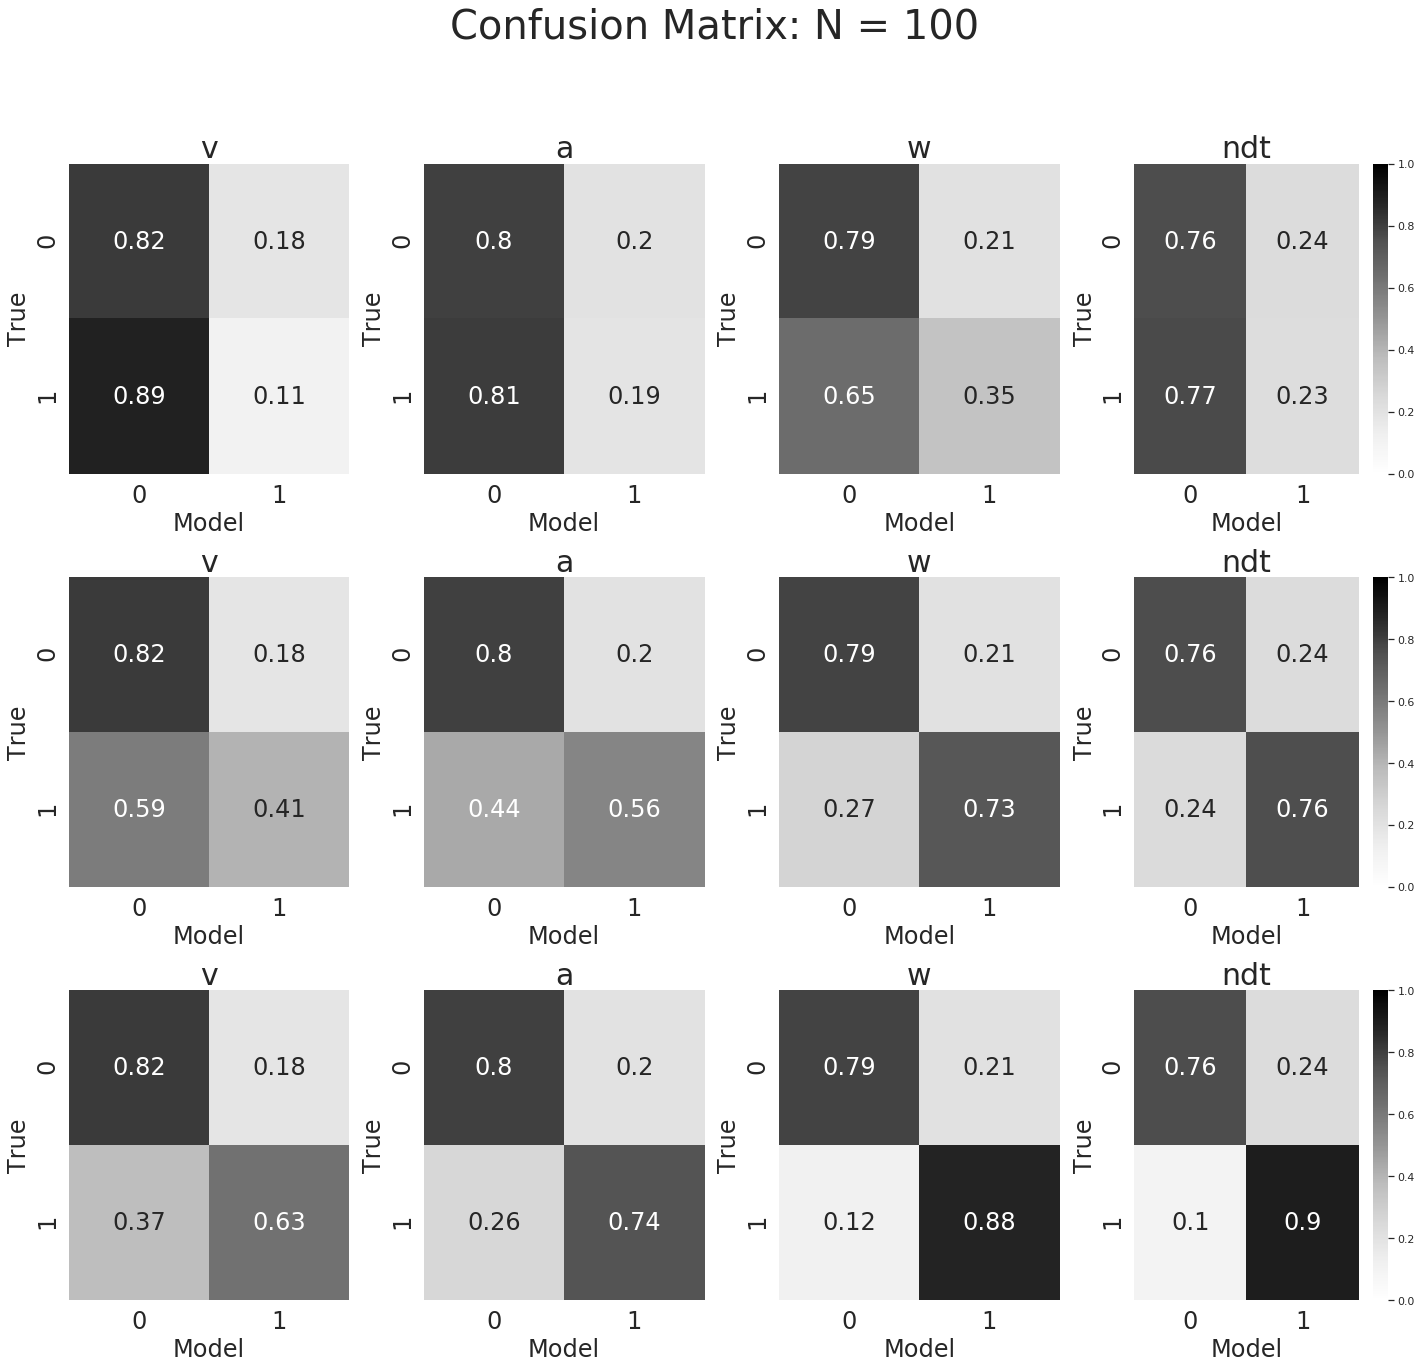

In [247]:
# n = 100
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 100',
                       data = out[0],
                       n_perturb = 3)

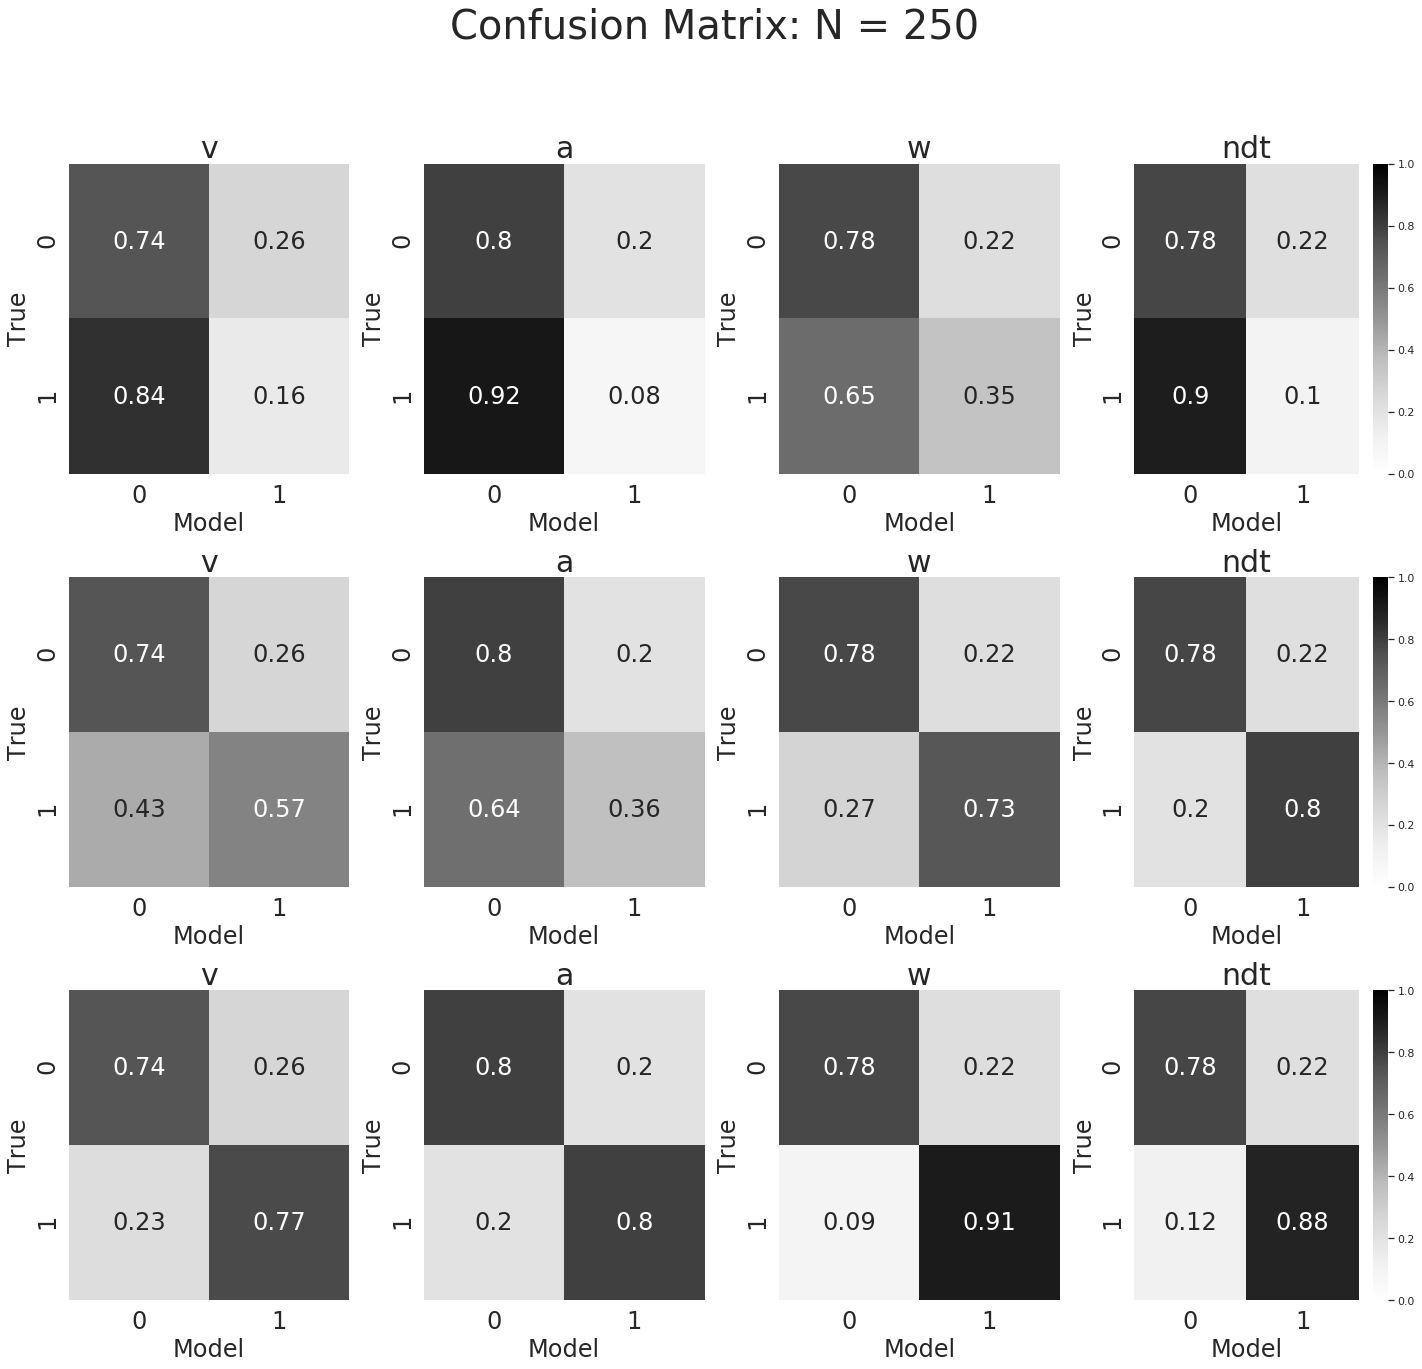

In [248]:
# n = 250
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 250',
                       data = out[1],
                       n_perturb = 3)

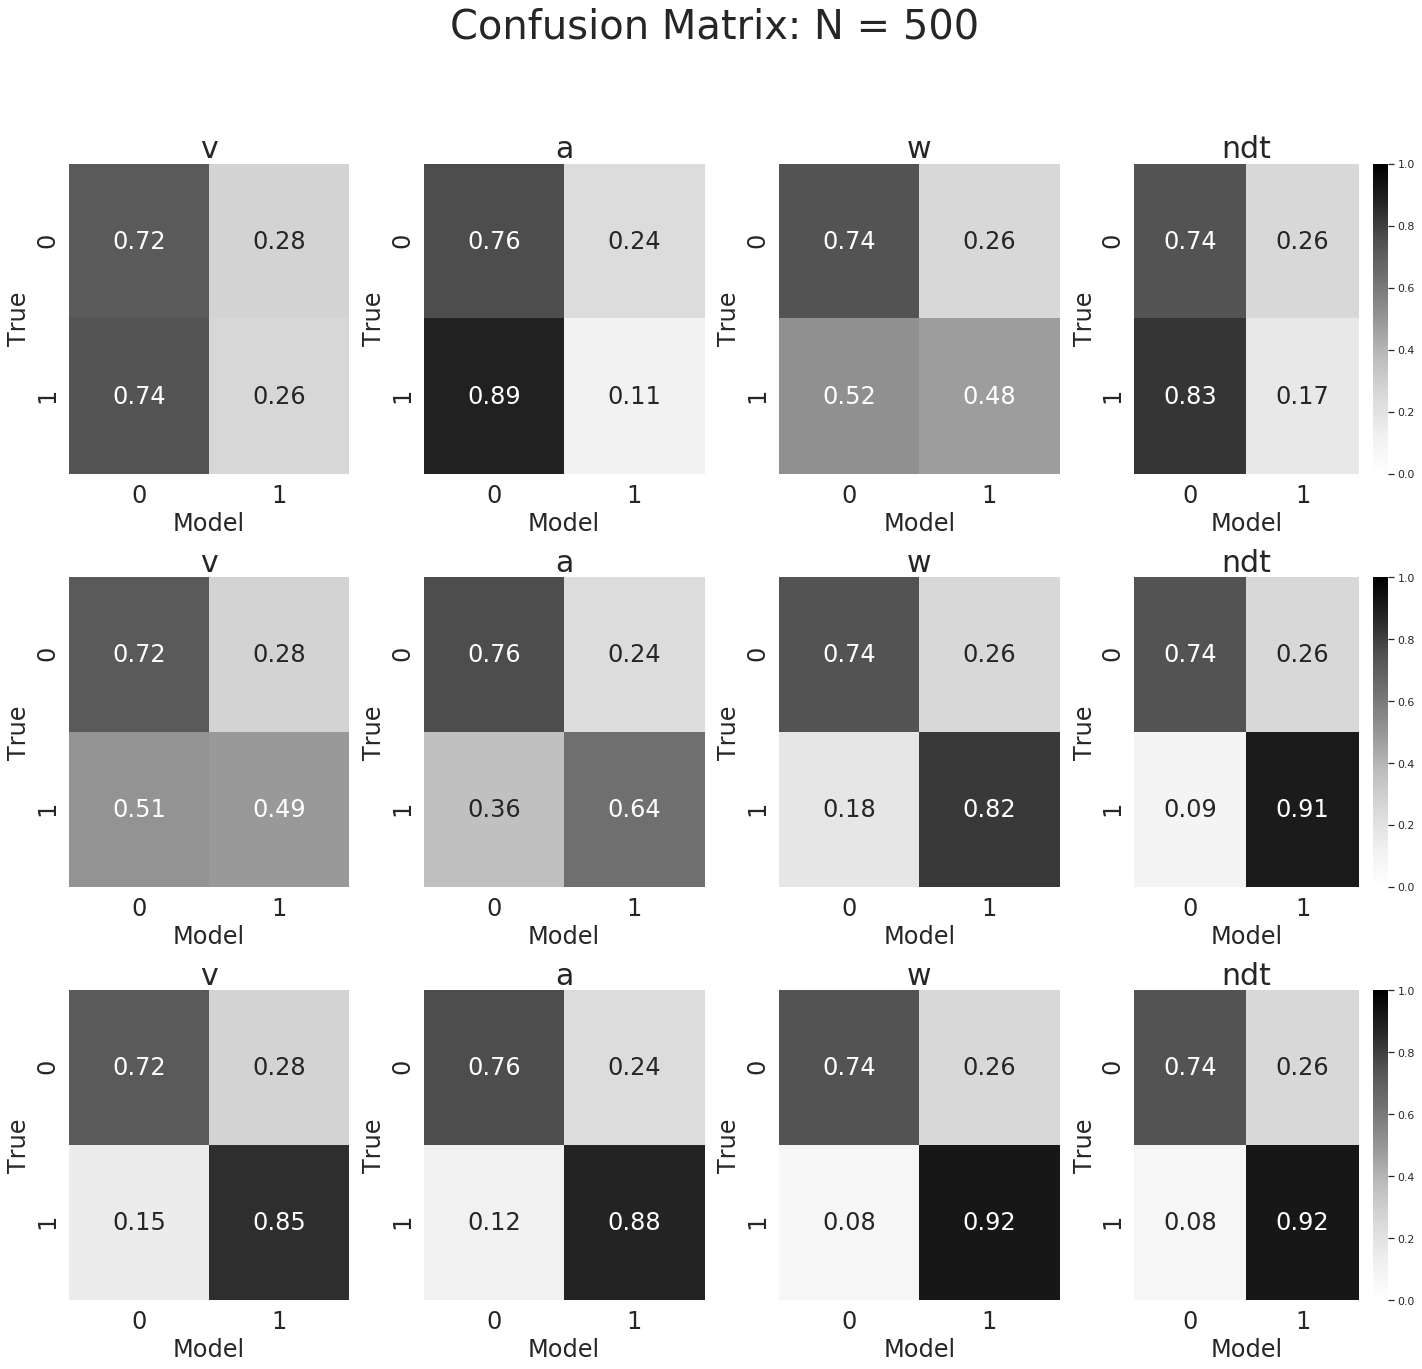

In [249]:
# n = 500
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 500',
                       data = out[2],
                       n_perturb = 3)

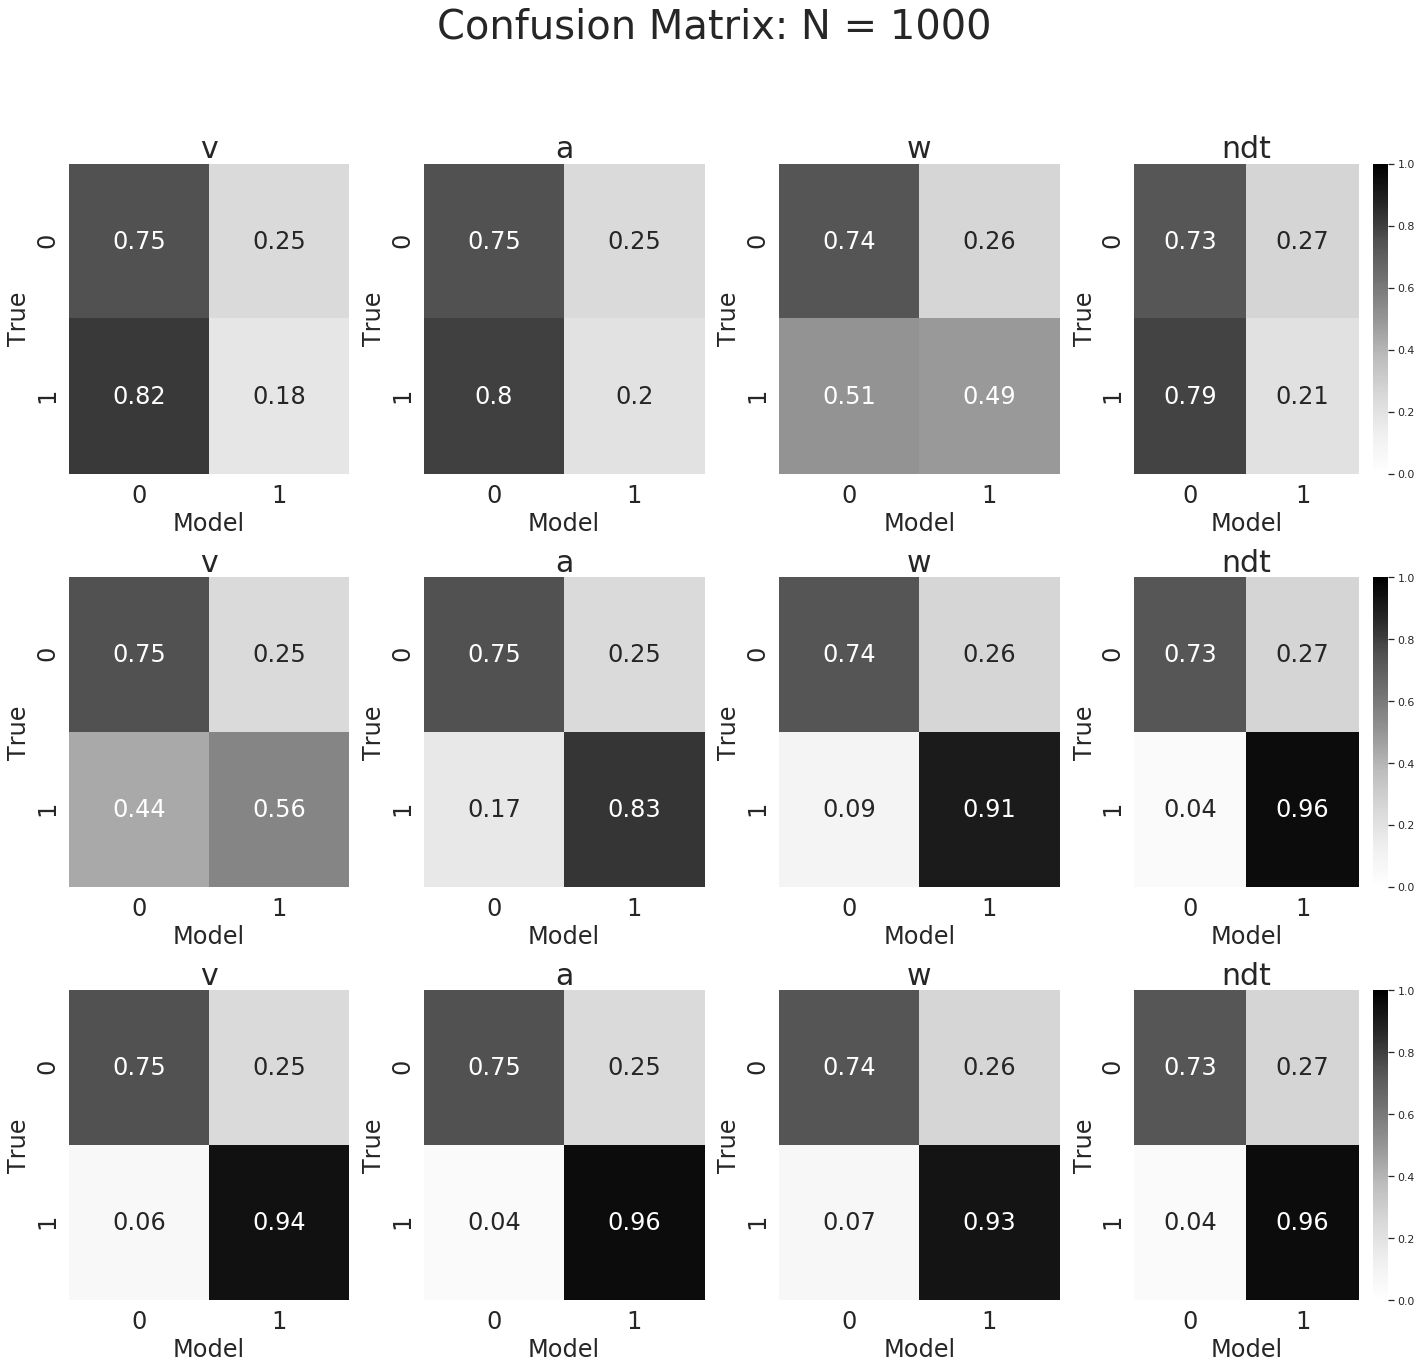

In [250]:
# n = 1000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 1000',
                       data = out[3],
                       n_perturb = 3)

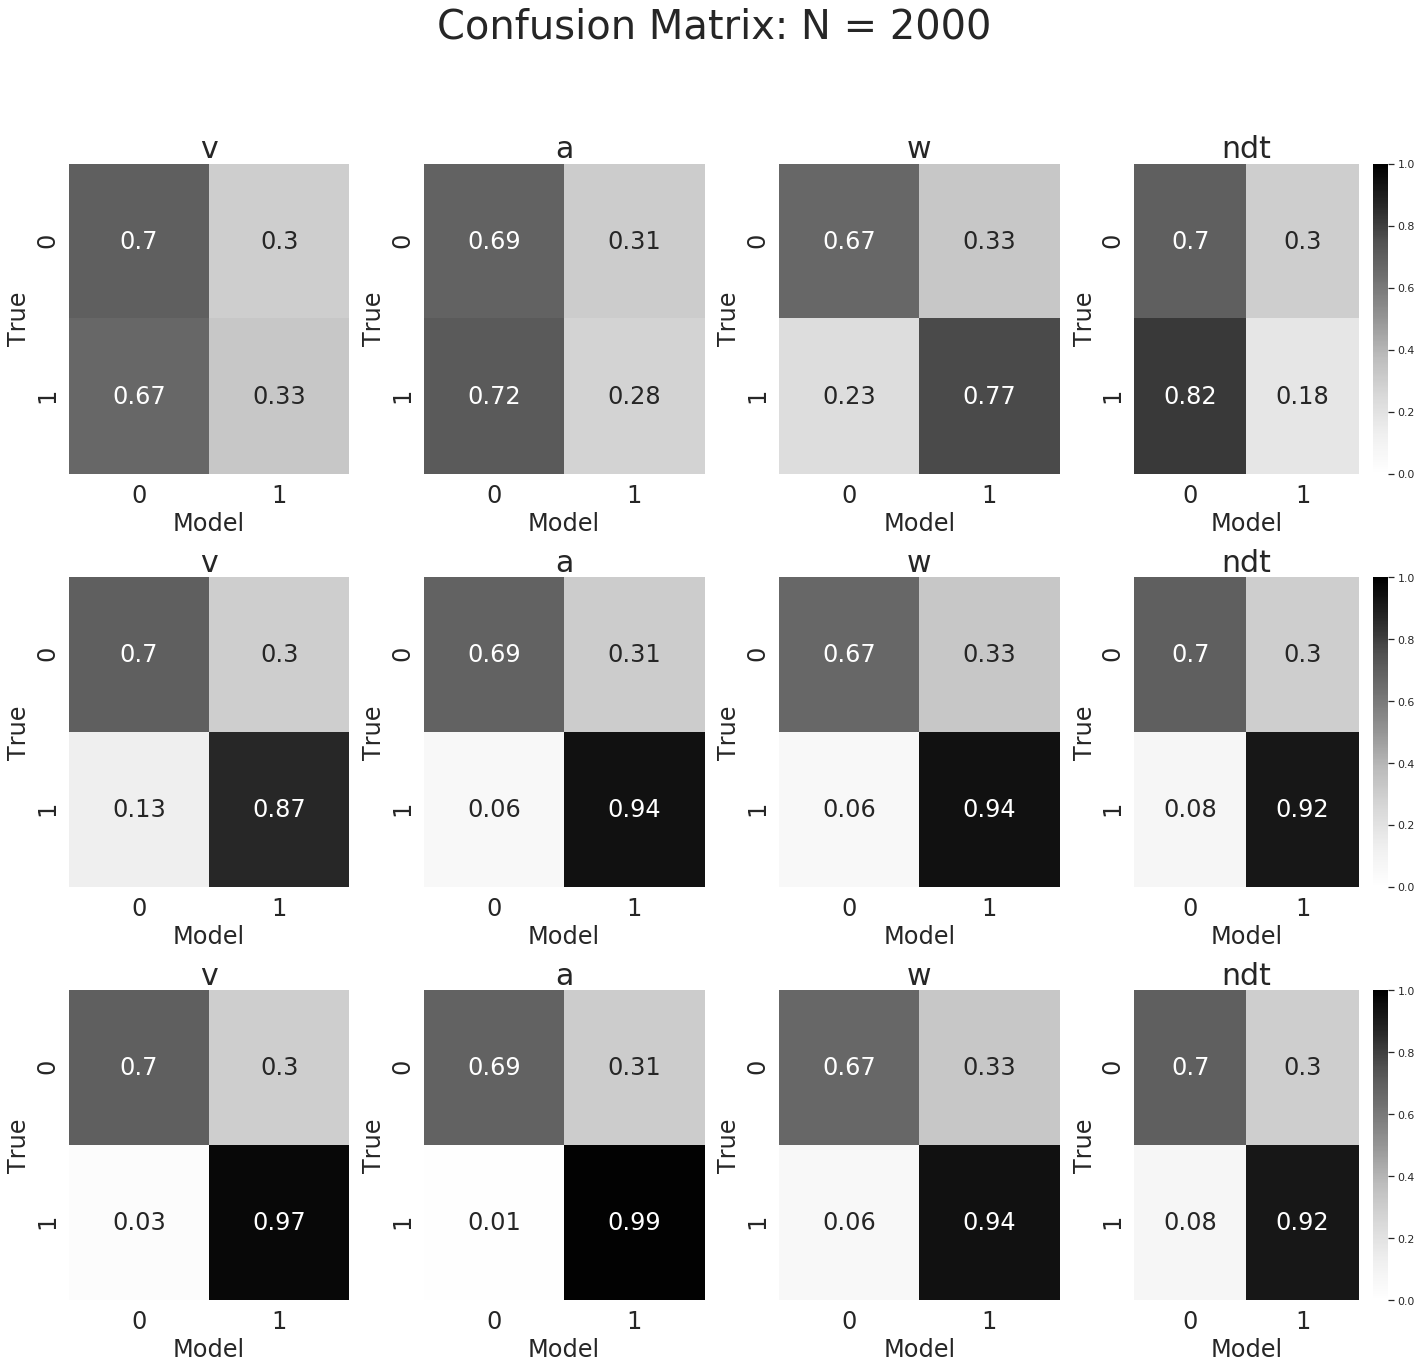

In [251]:
# n = 2000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 2000',
                       data = out[4],
                       n_perturb = 3)

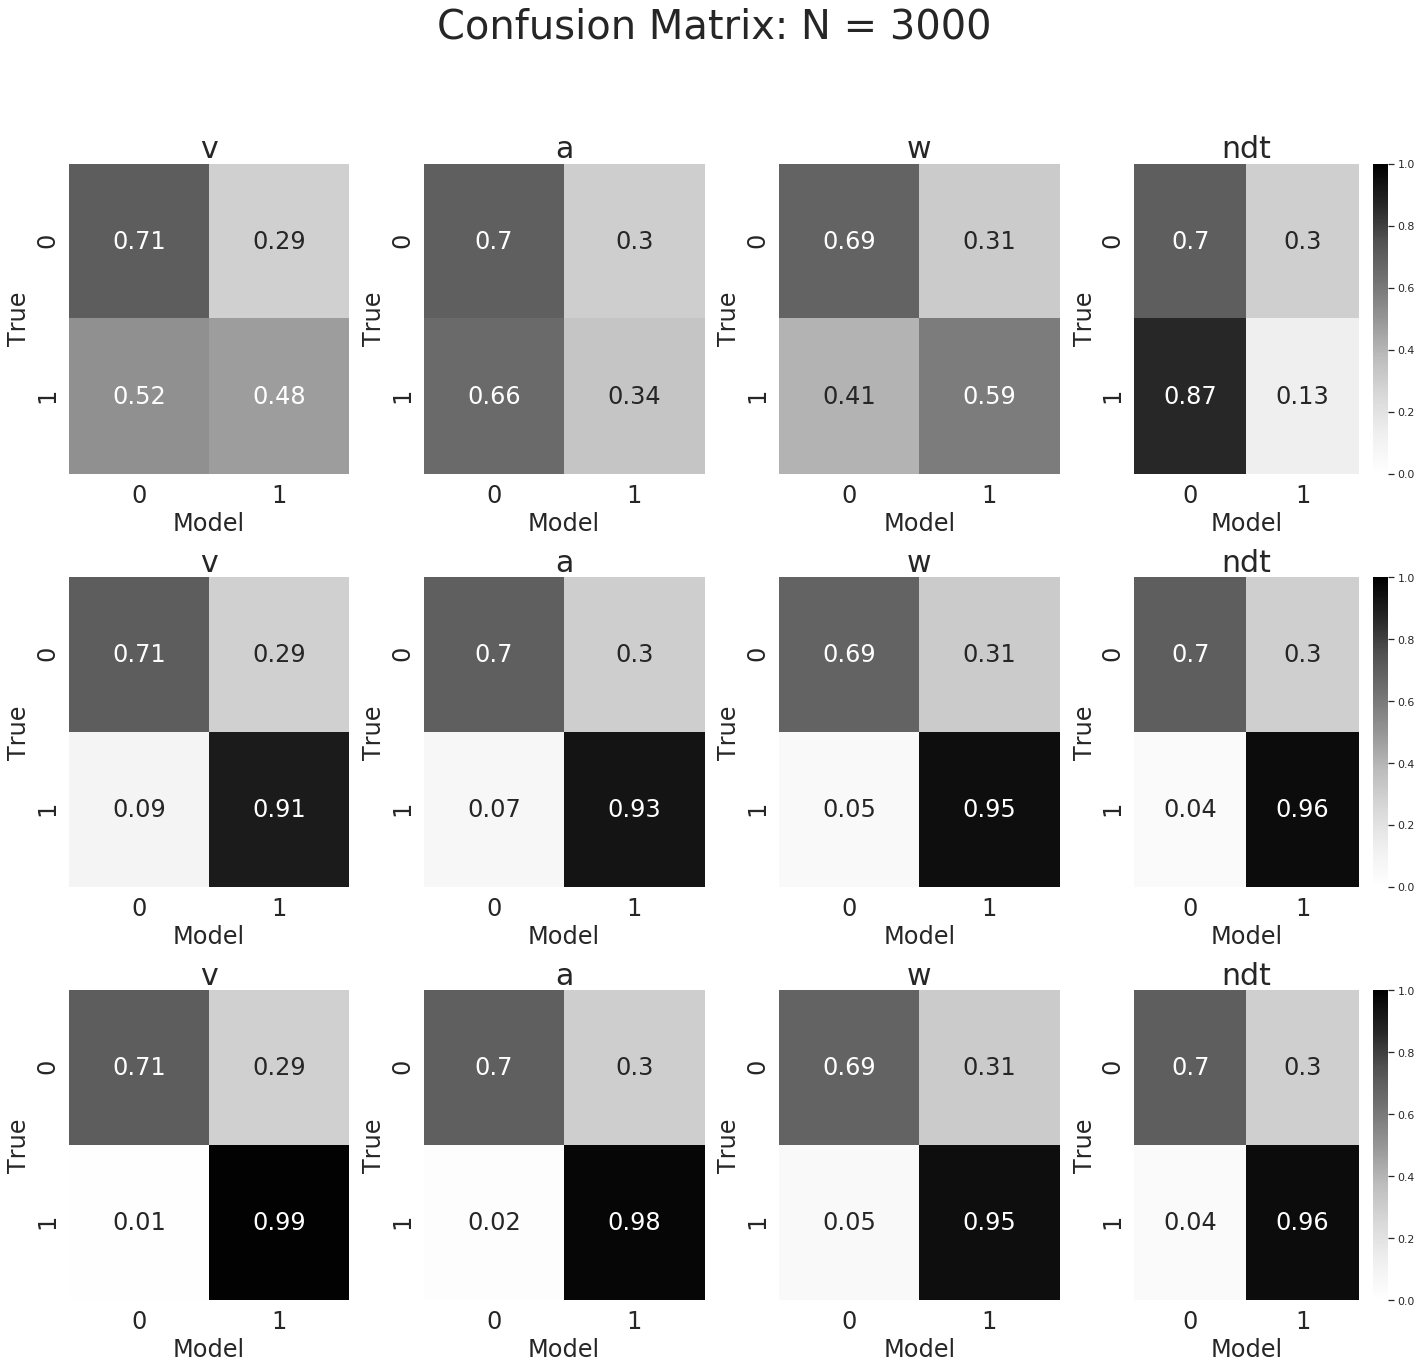

In [252]:
# n = 3000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 3000',
                       data = out[5],
                       n_perturb = 3)

In [255]:
# Analytic
sample_sizes = [100 , 250, 500, 1000, 2000, 3000]
file_folder = '/media/data_cifs/afengler/data/analytic/ddm/method_comparison/'
file_base_name = file_folder + 'post_samp_perturbation_experiment_nexp_1_n_'
detection_ratio_list_analytic = []
meta_data = pickle.load(open(glob.glob('/media/data_cifs/afengler/data/kde/ddm/method_comparison/base_data_perturbation_experiment_nexp_1*')[0], 'rb'))[2]
out_analytic = []

for sample_size in sample_sizes:
    files_ = glob.glob(file_base_name + str(sample_size) + '_*')
    files_.sort()
    out_analytic.append(bayesian_t_test_global(file_list = files_,
                                 meta_data = meta_data,
                                 kind = 'posterior_samples'))

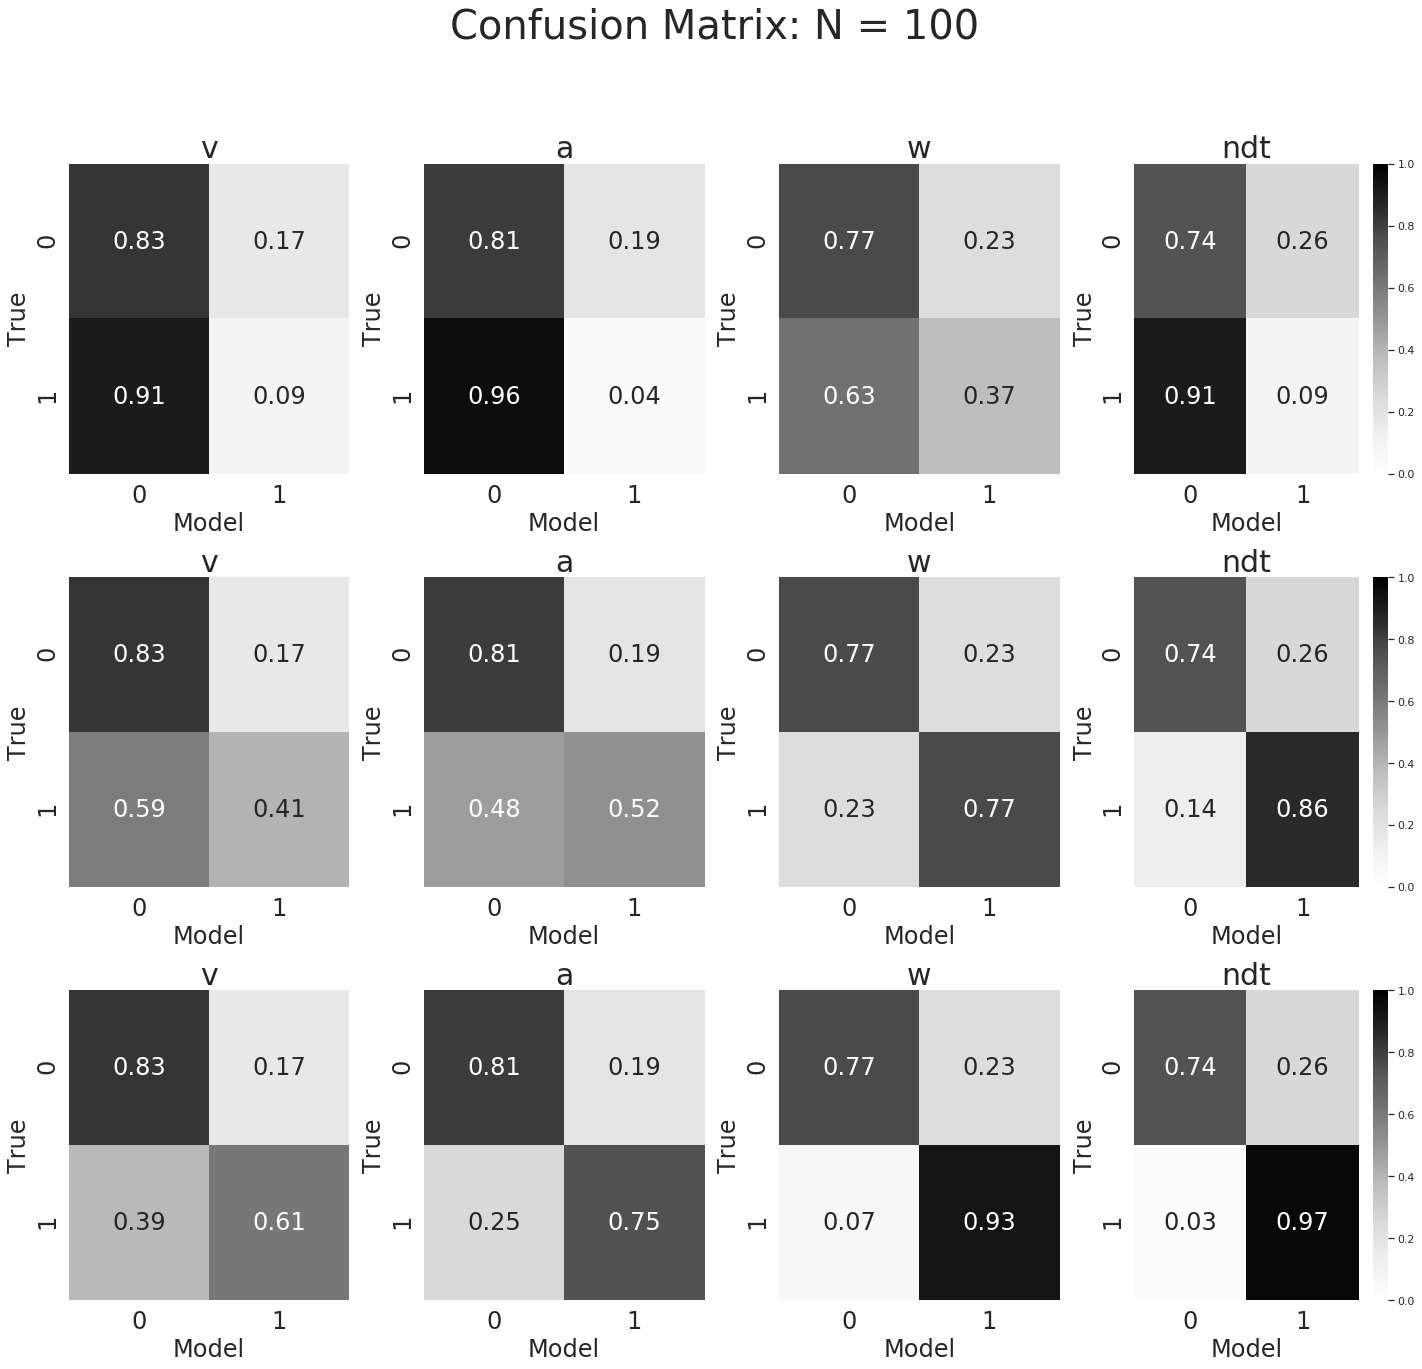

In [256]:
# n = 100
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 100',
                       data = out_analytic[0],
                       n_perturb = 3)

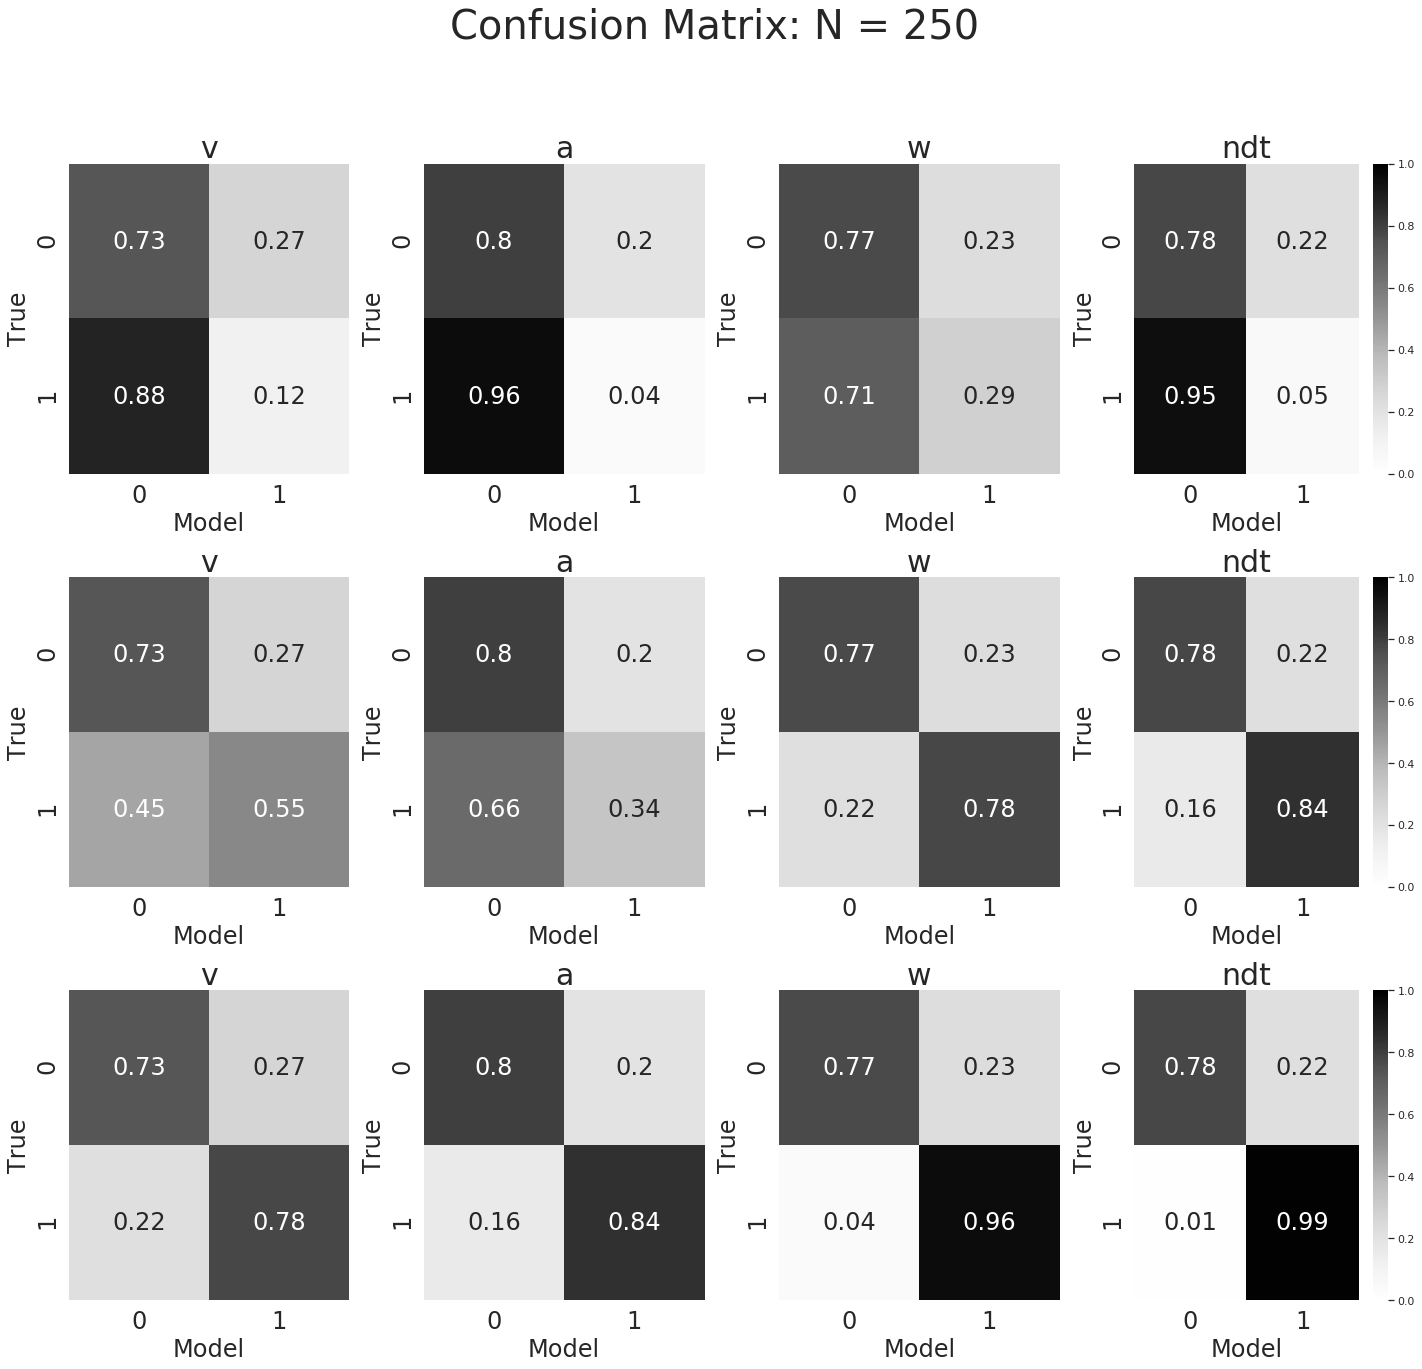

In [257]:
# n = 250
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 250',
                       data = out_analytic[1],
                       n_perturb = 3)

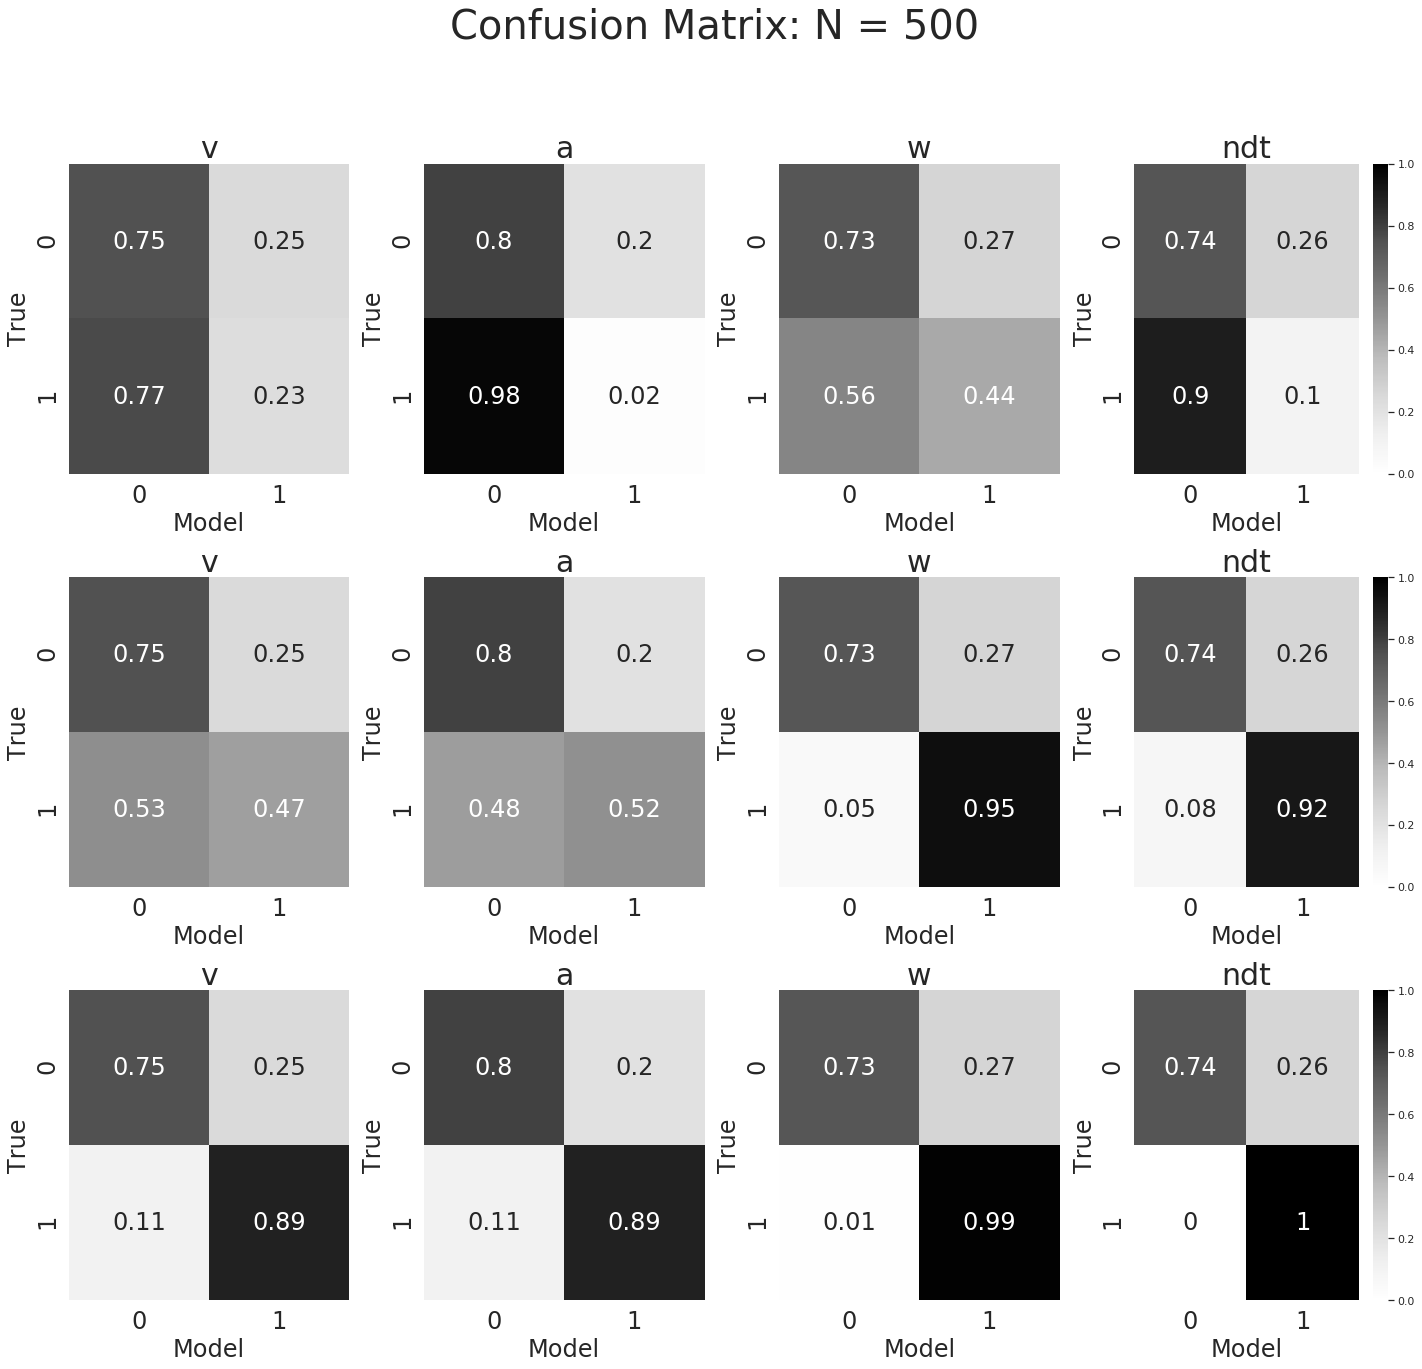

In [258]:
# n = 500
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 500',
                       data = out_analytic[2],
                       n_perturb = 3)

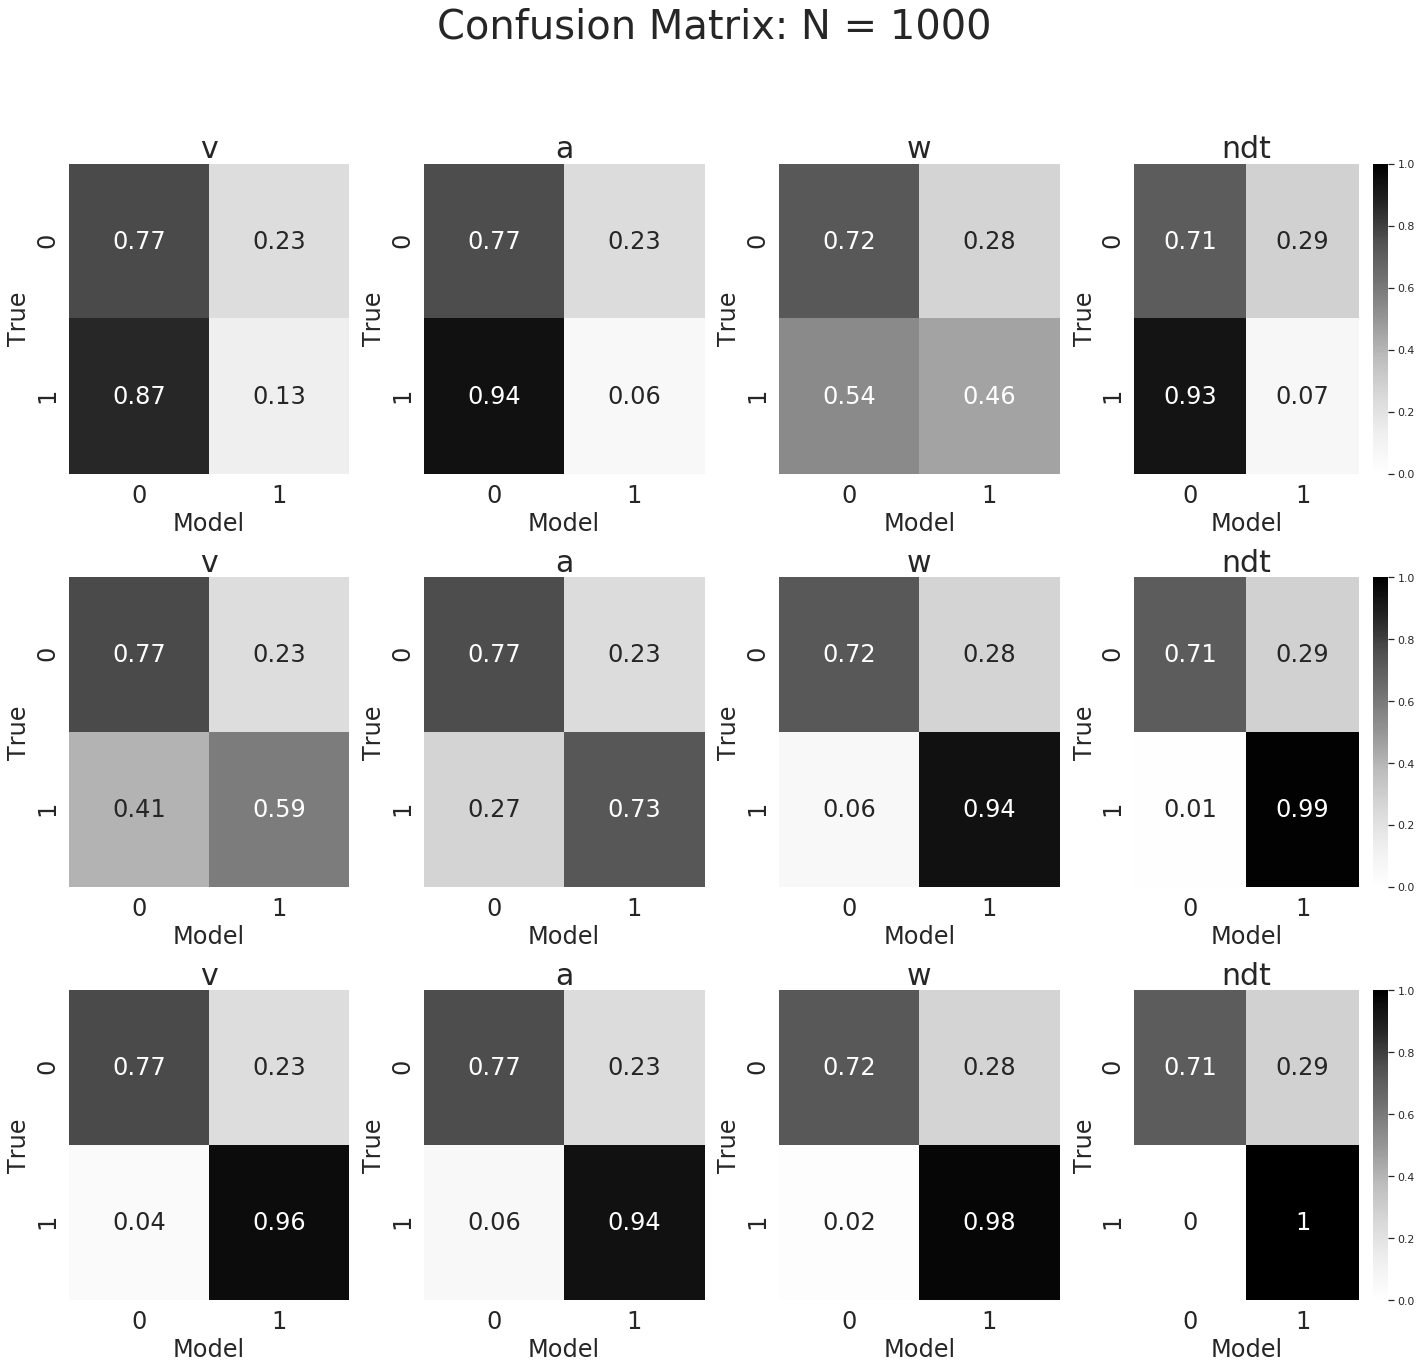

In [259]:
# n = 1000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 1000',
                       data = out_analytic[3],
                       n_perturb = 3)

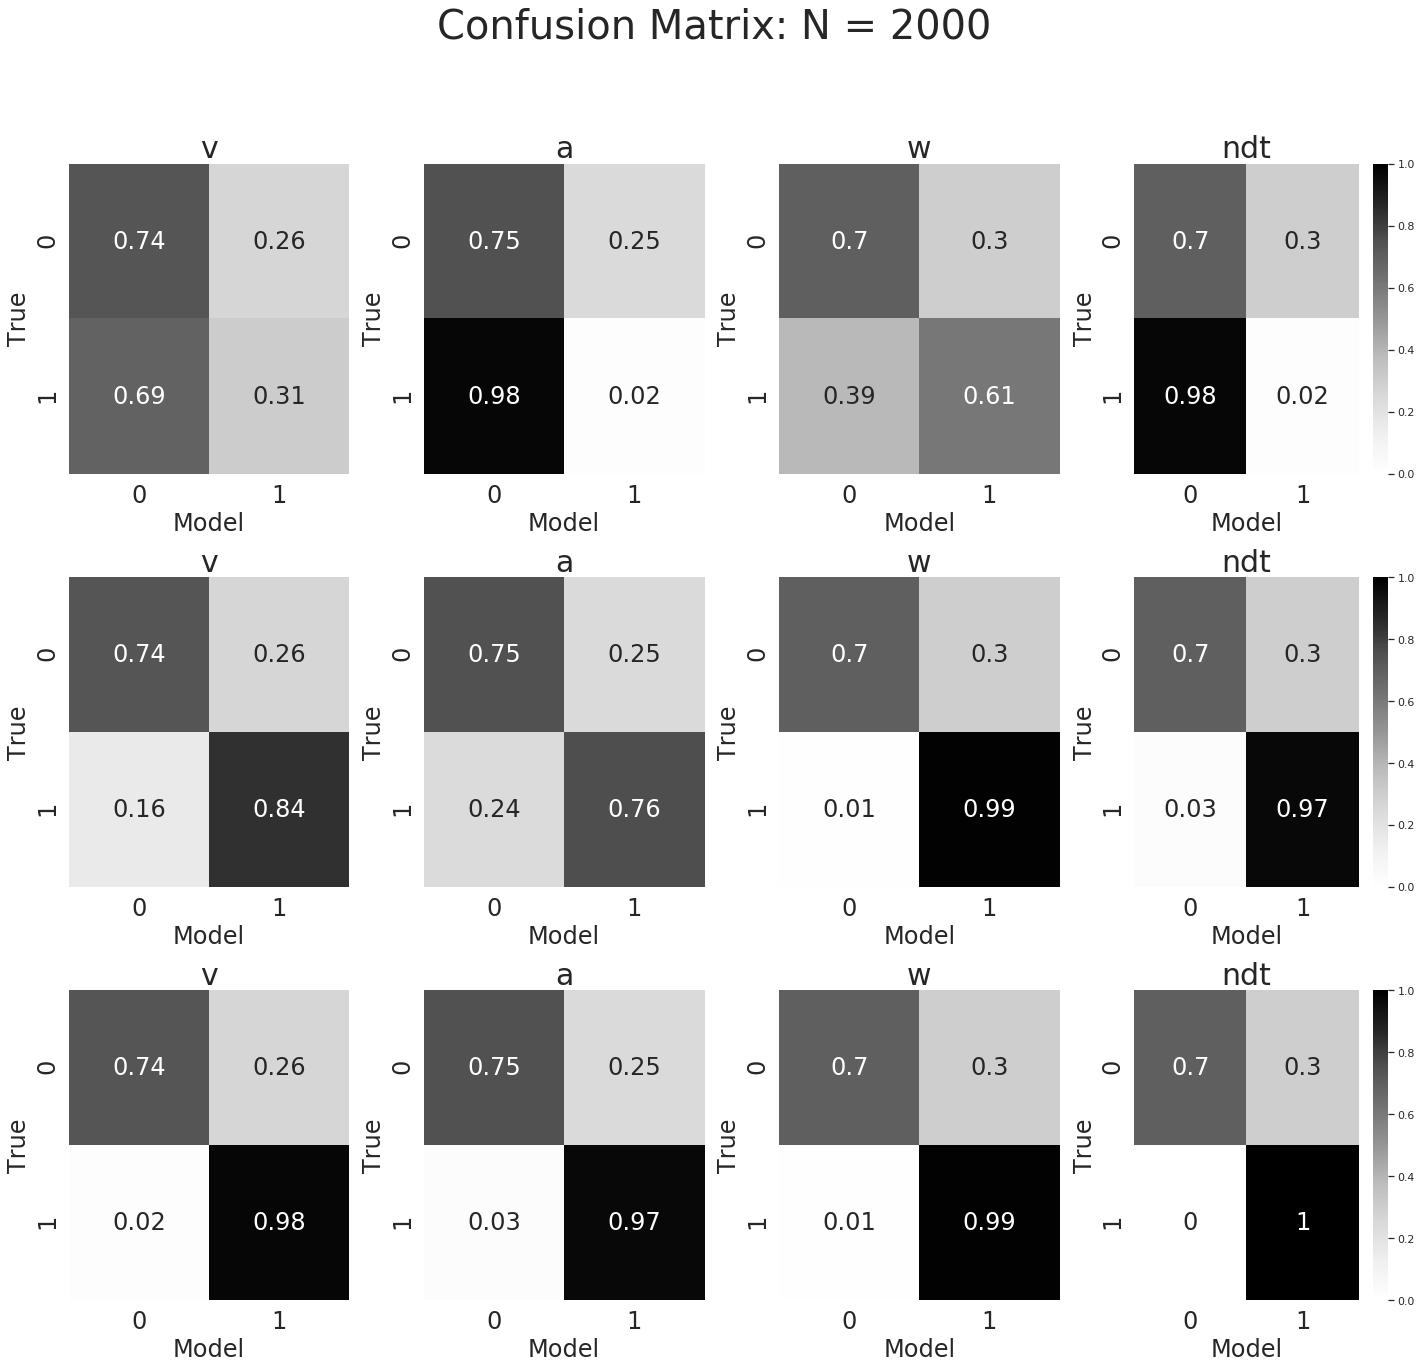

In [260]:
# n = 2000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 2000',
                       data = out_analytic[4],
                       n_perturb = 3)

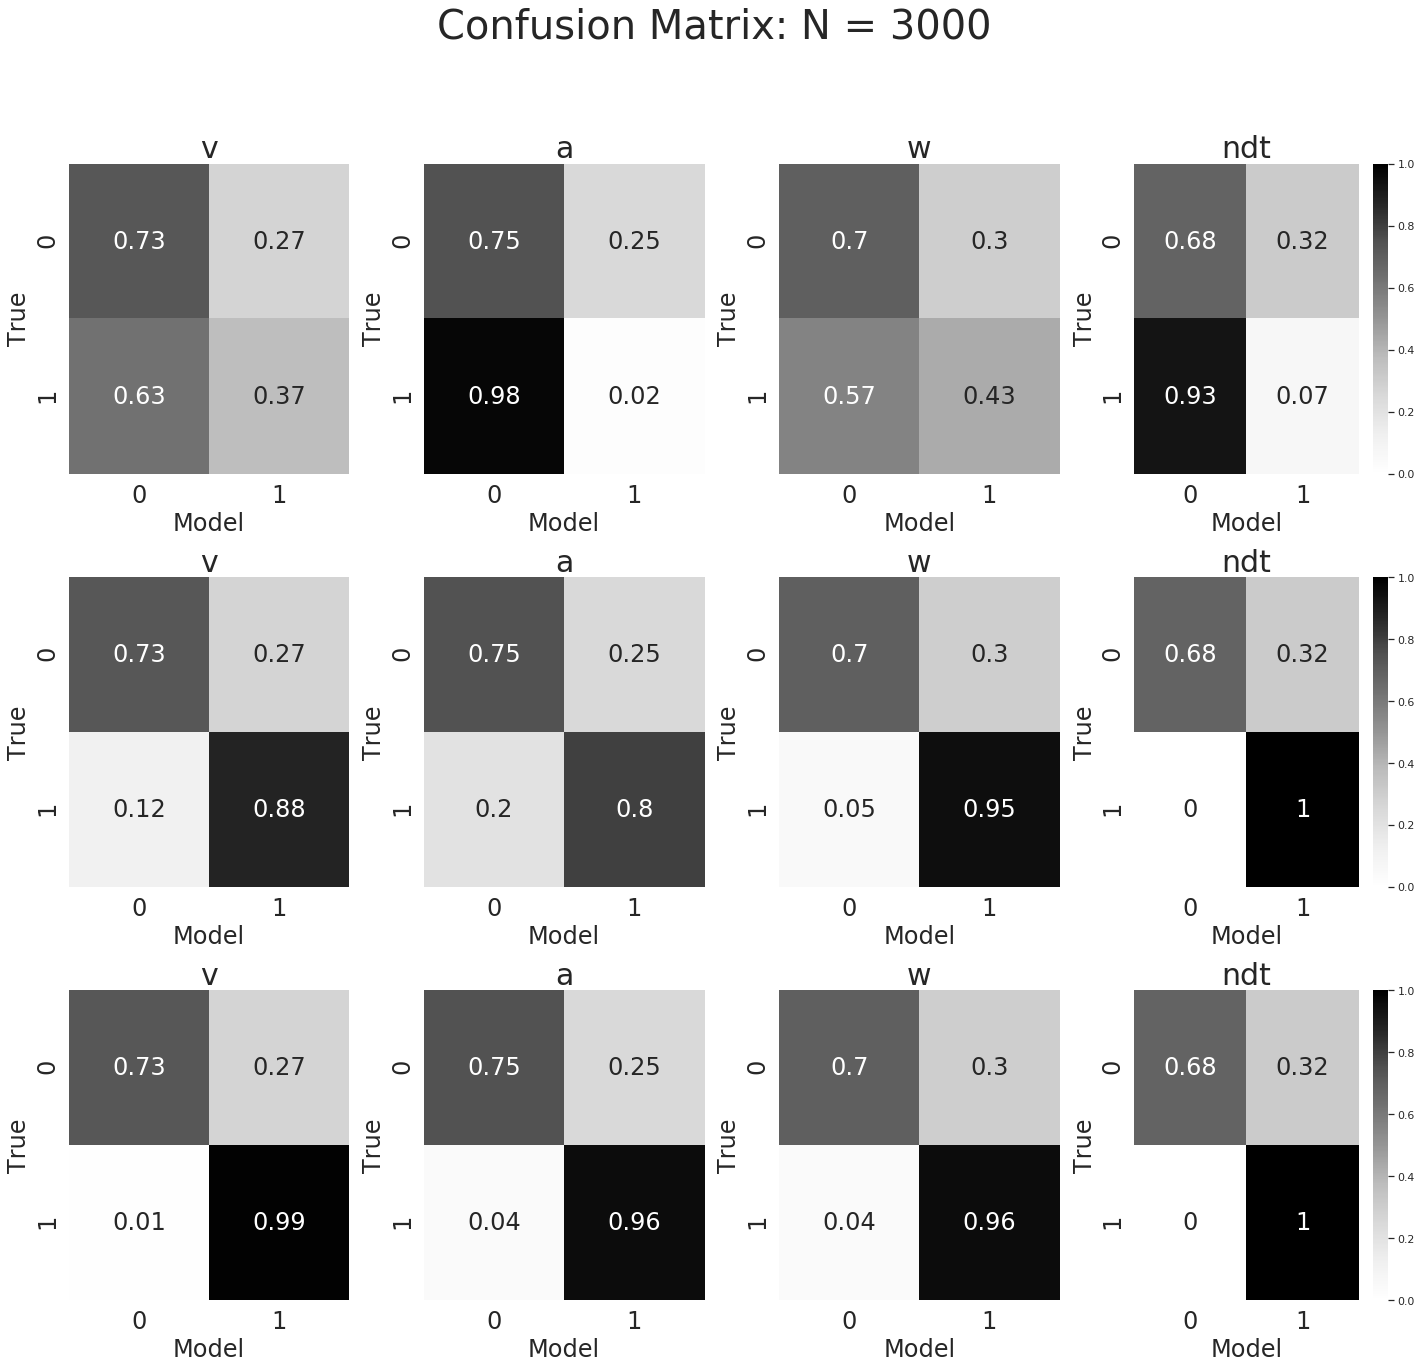

In [261]:
# n = 3000
confusion_matrix_plots(ax_titles = ['v', 'a', 'w', 'ndt'],
                       title = 'Confusion Matrix: N = 3000',
                       data = out_analytic[5],
                       n_perturb = 3)

In [147]:
# FCN

# Initializations
sample_sizes = [100 , 250, 500, 1000, 2000, 3000]
file_folder = '/media/data_cifs/afengler/data/kde/ddm/method_comparison/'
file_base_name = file_folder + 'deep_inference_perturbation_experiment_nexp_1_n_'
detection_ratio_list_fcn = []

# Load meta_data file (assumed to be same across all experiment datasets)
meta_data = pickle.load(open(glob.glob(file_folder + 'base_data_perturbation_experiment_nexp_1*')[0], 'rb'))[2]

# Get detection ratios for all experiments
for sample_size in sample_sizes:
    files_ = glob.glob(file_base_name + str(sample_size) + '_*')
    files_.sort()
    out = bayesian_t_test_global(file_list = files_,
                                 meta_data = meta_data,
                                 kind = 'fcn')
    
    detection_ratio_list_fcn.append(get_detection_ratios(out))

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_1.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_10.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_100.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_11.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_12.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_13.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_14.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_15.pickle
/media/data_cifs/afengler/data/kde/ddm/method_co

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_71.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_72.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_73.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_74.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_75.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_76.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_77.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_100_78.pickle
/media/data_cifs/afengler/data/kde/ddm/method_co

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_45.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_46.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_47.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_48.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_49.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_5.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_50.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_250_51.pickle
/media/data_cifs/afengler/data/kde/ddm/method_com

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_17.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_18.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_19.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_2.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_20.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_21.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_22.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_23.pickle
/media/data_cifs/afengler/data/kde/ddm/method_com

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_8.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_80.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_81.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_82.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_83.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_84.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_85.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_500_86.pickle
/media/data_cifs/afengler/data/kde/ddm/method_com

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_53.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_54.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_55.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_56.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_57.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_58.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_59.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_1000_6.pickle
/media/data_cifs/afengler/data/kde/ddm/me

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_25.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_26.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_27.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_28.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_29.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_3.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_30.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_31.pickle
/media/data_cifs/afengler/data/kde/ddm/me

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_88.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_89.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_9.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_90.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_91.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_92.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_93.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_2000_94.pickle
/media/data_cifs/afengler/data/kde/ddm/me

/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_61.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_62.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_63.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_64.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_65.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_66.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_67.pickle
/media/data_cifs/afengler/data/kde/ddm/method_comparison/deep_inference_perturbation_experiment_nexp_1_n_3000_68.pickle
/media/data_cifs/afengler/data/kde/ddm/m

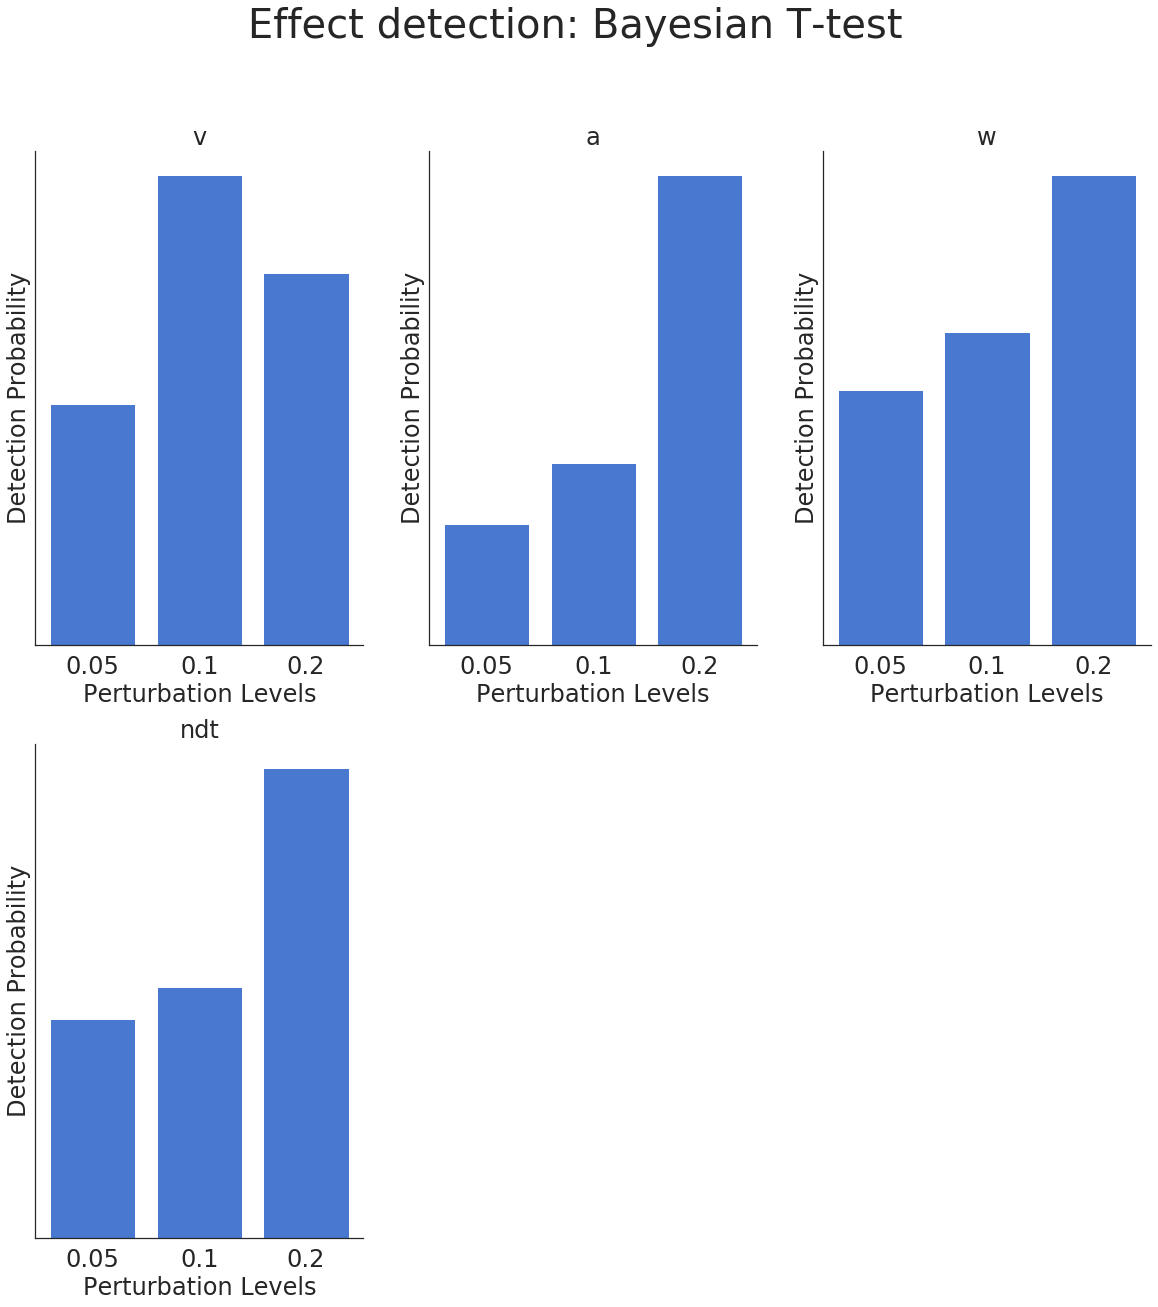

In [148]:
# n = 100
detection_rate_plots(data = detection_ratio_list_fcn[0])

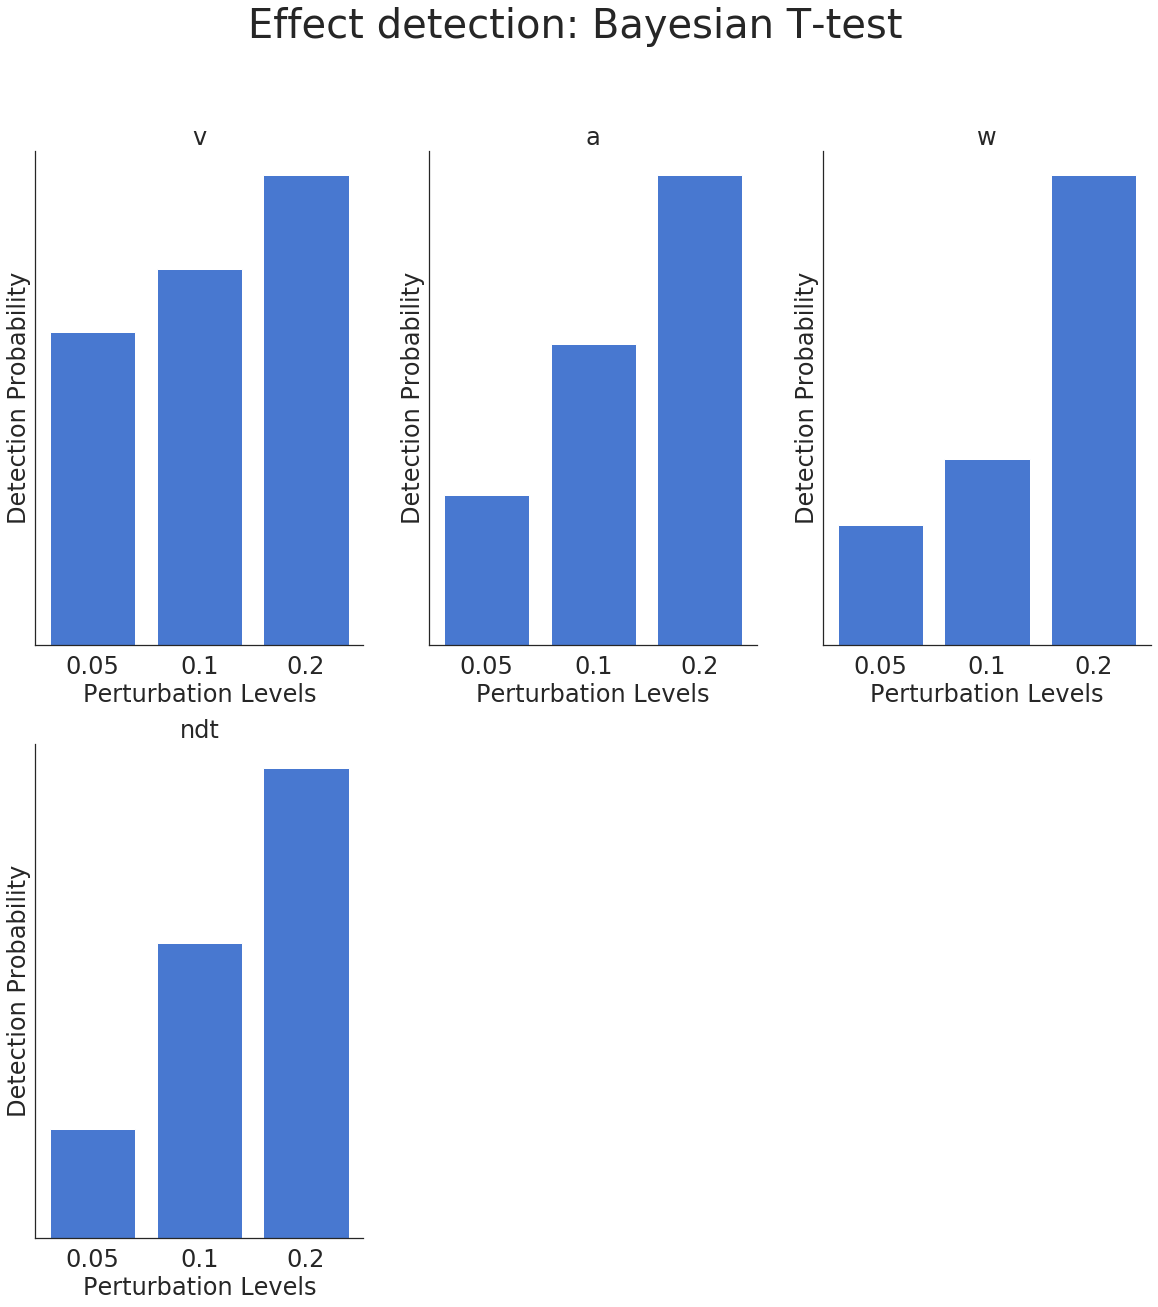

In [149]:
# n = 250
detection_rate_plots(data = detection_ratio_list_fcn[1])

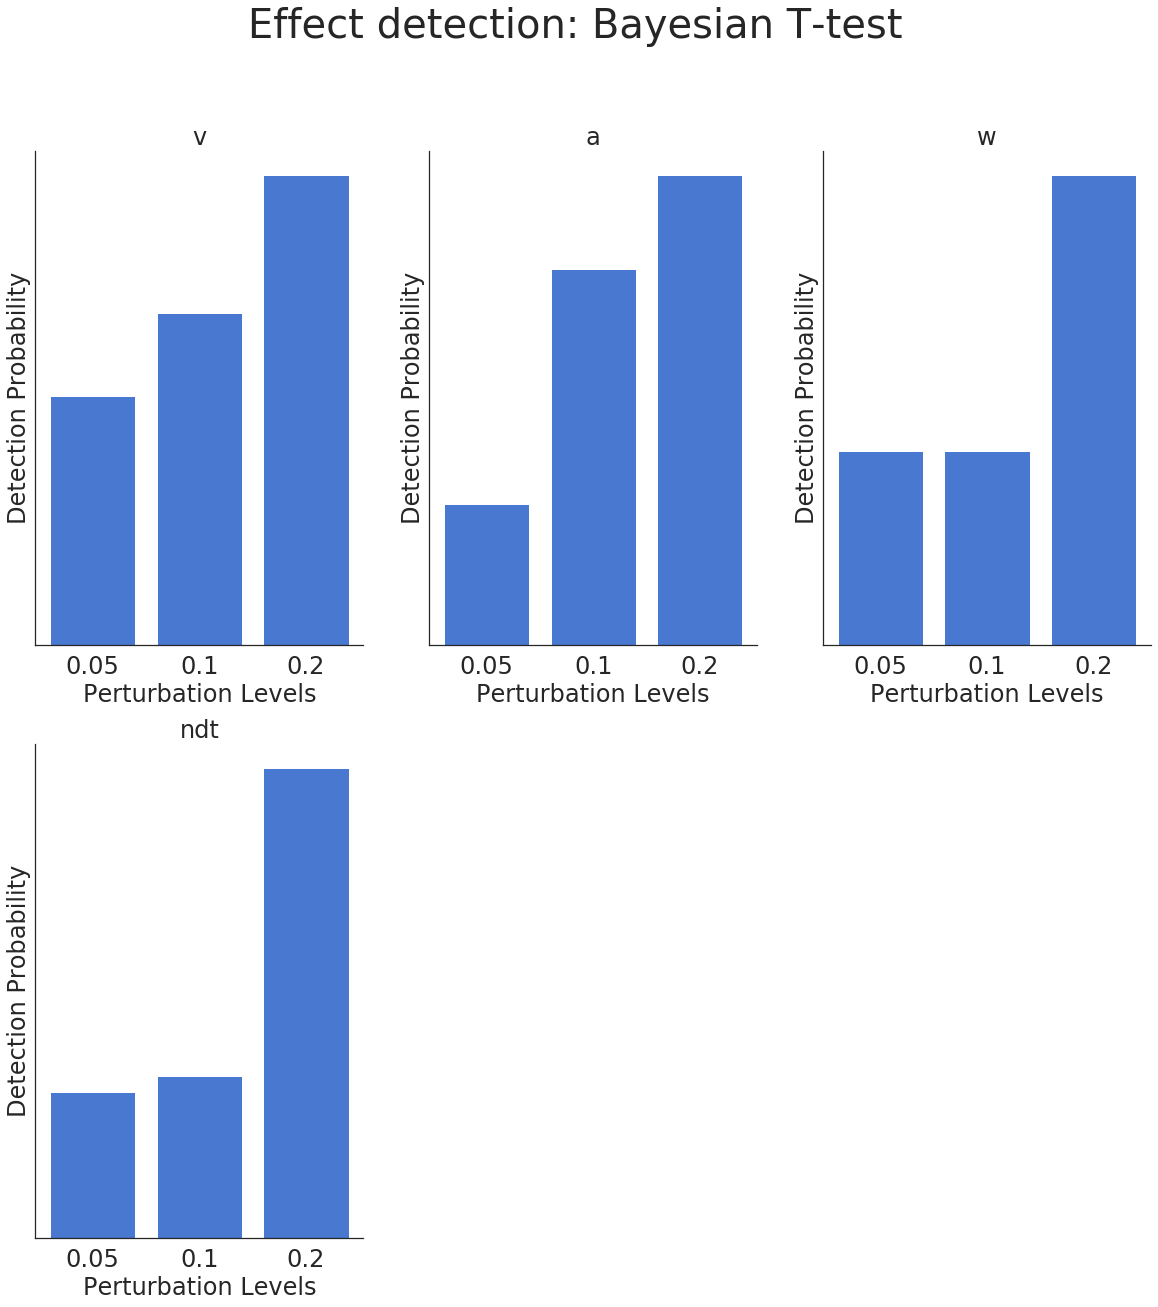

In [150]:
# n = 500
detection_rate_plots(data = detection_ratio_list_fcn[2])

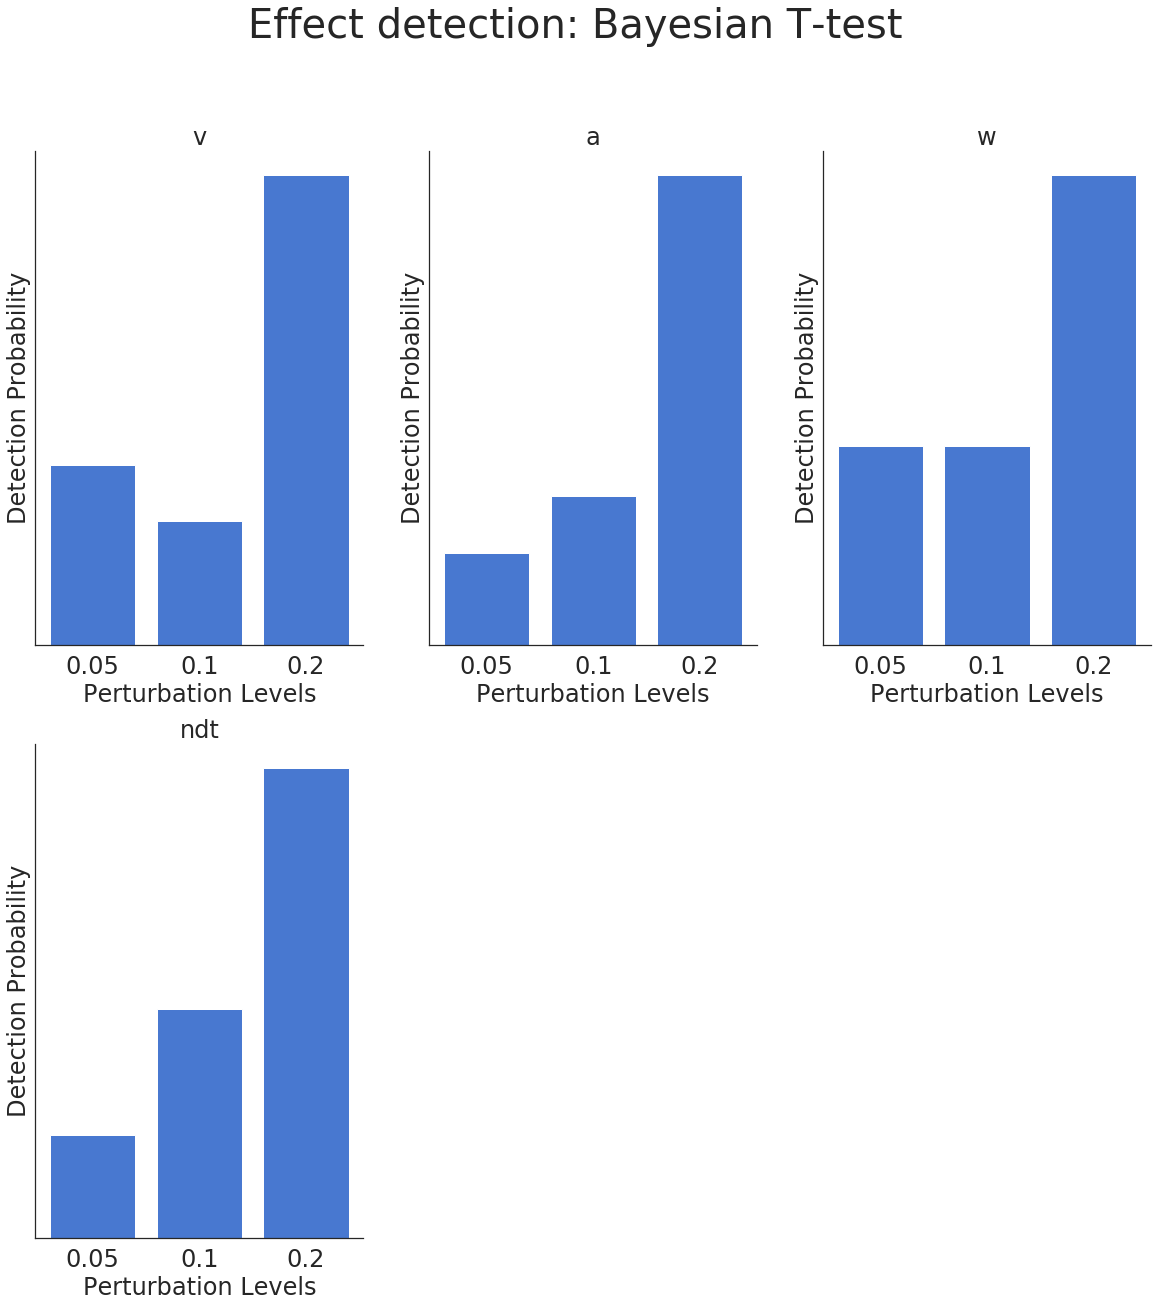

In [151]:
# n = 1000
detection_rate_plots(data = detection_ratio_list_fcn[3])

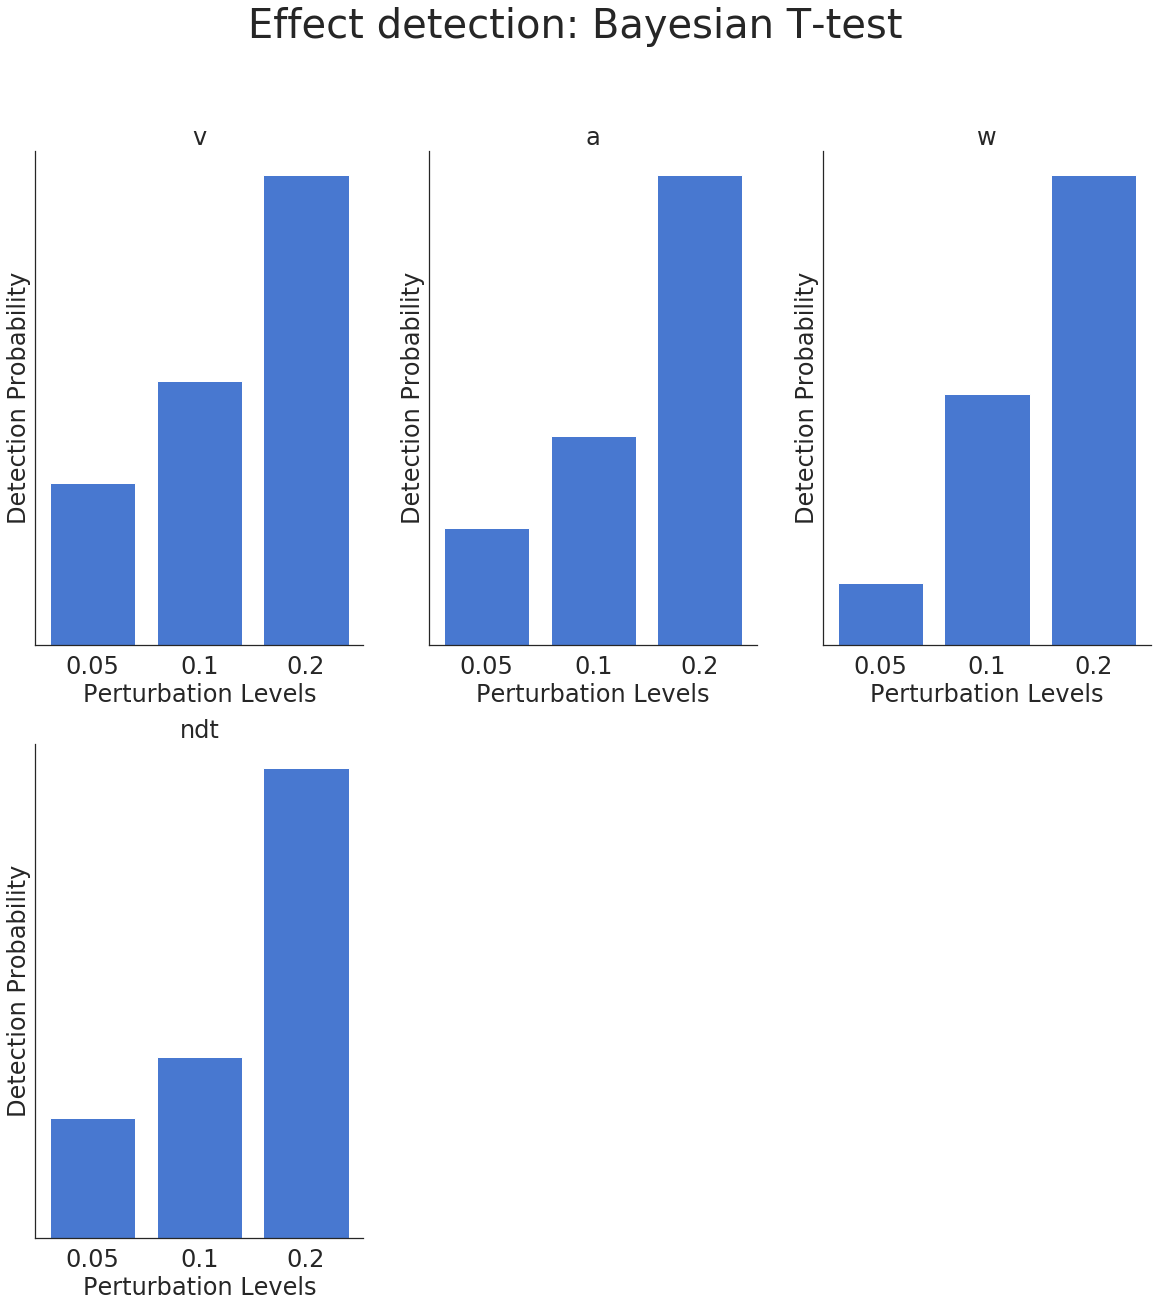

In [152]:
# n = 2000
detection_rate_plots(data = detection_ratio_list_fcn[4])

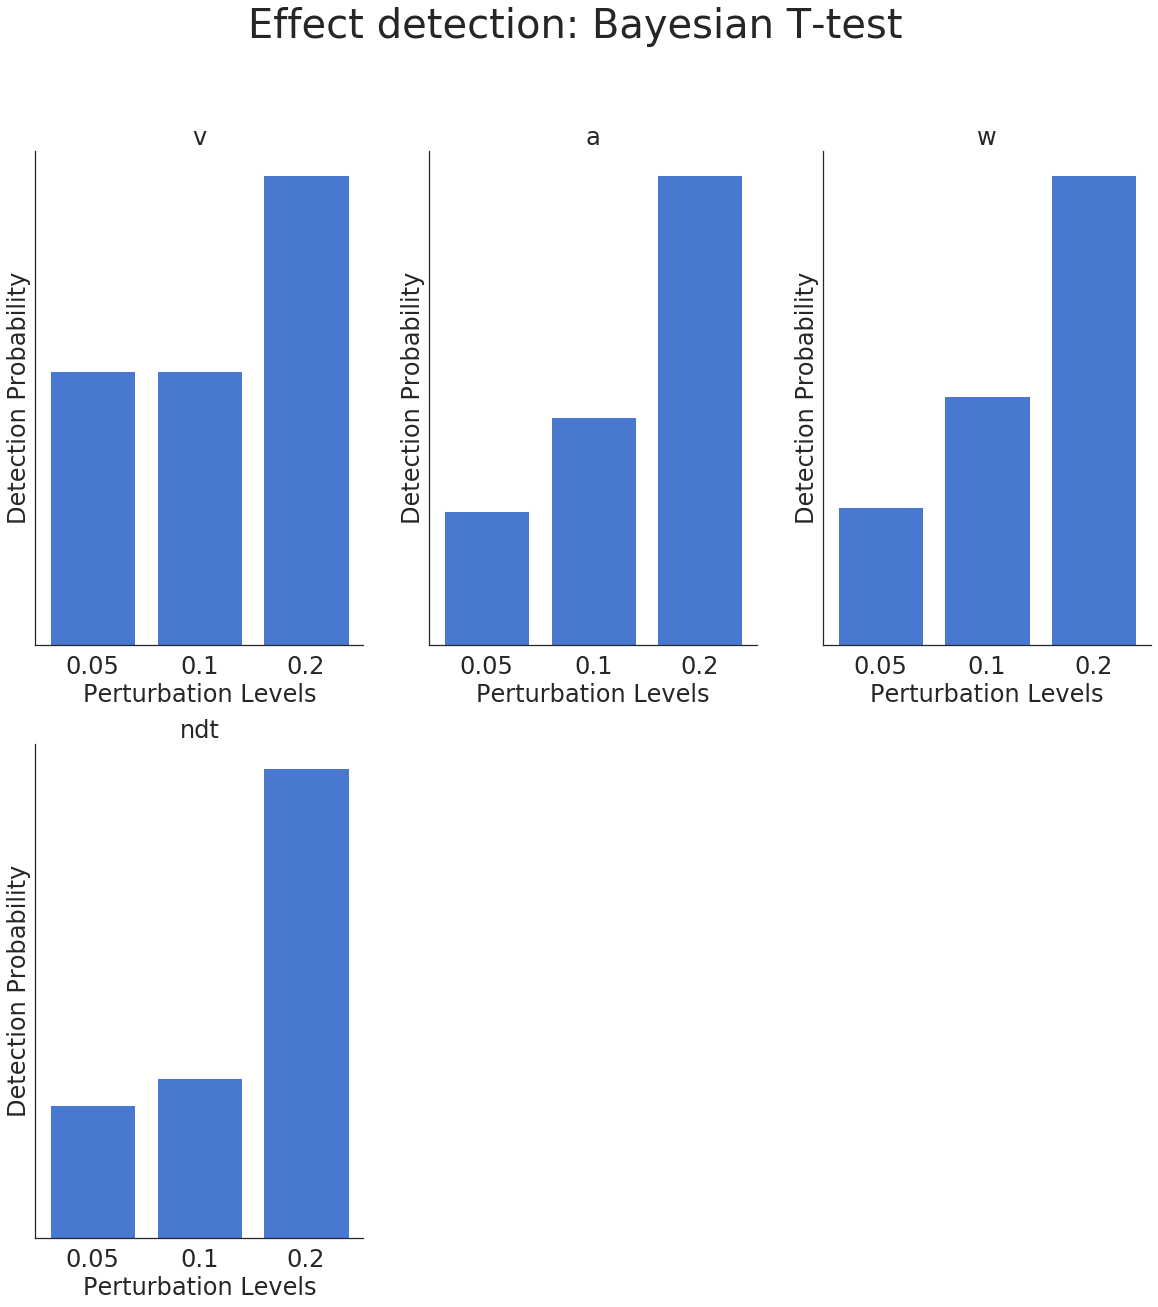

In [153]:
# n = 3000
detection_rate_plots(data = detection_ratio_list_fcn[5])

In [40]:
T = np.linspace(0, 10, 10000)

In [16]:
int(np.floor(10.5))

10

In [17]:
floor(10.5)

NameError: name 'floor' is not defined